### Setup packages 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install progressbar
%pip install plotnine
%pip install torch
%pip install ipython-autotime
%pip install ggplot
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=41892bf3508a619332ce9ba432b53b898ca2b140b0ab7c8af1c775bf0fb2988a
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 15.5 MB/s 
time: 134 µs (started: 2022-07-30 07:49:05 +00:00)


In [3]:
from plotnine import *
from plotnine.themes import *

time: 1.77 s (started: 2022-07-30 07:49:05 +00:00)


In [4]:
from scipy.io import loadmat
import random
import math
from tqdm import tqdm

time: 44.1 ms (started: 2022-07-30 07:49:06 +00:00)


_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [5]:
paper_name = "dgm_cj_10p2"

time: 999 µs (started: 2022-07-30 07:49:07 +00:00)


In [6]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")

time: 33.7 ms (started: 2022-07-30 07:49:07 +00:00)


In [7]:
# Set up the imports
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

import site
import os
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


time: 32 ms (started: 2022-07-30 07:49:07 +00:00)


In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import norm
from matplotlib import cm
import pdb
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.optim.swa_utils import AveragedModel, SWALR

time: 2.35 s (started: 2022-07-30 07:49:07 +00:00)


In [9]:
import plotly.graph_objects as go
import plotly.express as px
from pprint import pprint as pp

time: 1.73 s (started: 2022-07-30 07:49:09 +00:00)


### Shared functions across models

In [ ]:
import pandas as pd

def plot_report(train_instance):
        
    history_tl_cpu = [ x for x in train_instance.history_tl ]
    history_internal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_internal_cpu ]
    history_terminal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_terminal ]
    history_initial_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_initial ]
    history_nonzero_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_nonzero ]

    obs_data = pd.DataFrame({"Epochs" : [ (x+1)*train_instance.hook_interval for x in range(len(history_initial_cpu))], 
                             "AvgLogLoss": np.log(history_tl_cpu), 
                             "TerminalLogLoss" :  np.log(history_terminal_cpu),
                             "InternalLogLoss" :  np.log(history_internal_cpu),
                             "InitialLogLoss" : np.log(history_initial_cpu),
                             "NonZeroLogLoss" : np.log(history_nonzero_cpu),
                             })

    return (ggplot(obs_data, aes("Epochs","AvgLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","TerminalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InternalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InitialLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","NonZeroLogLoss")) + geom_line() + geom_point(),
            )

def plot_activation_mean(train_instance):
    
    # pdb.set_trace()

    if train_instance.debug == False:
        print( 'error: debug is off , turn it on and train again ' )
    else:
        history = np.array(train_instance.history_mean_hooks)
        jet= plt.get_cmap('jet')
        colors = iter(jet(np.linspace(0,1,10)))
        fig, ax = plt.subplots()
        for i in range(history.shape[1]):
            ax.plot(history[:,i], '--r', label= i , color=next(colors) )
        fig.suptitle('Layers activation mean value', fontsize=10)
        leg = ax.legend();


time: 25.1 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
# a set up that just maximizes the loss s.t. loss < eps (maximizeloss_weights_st) using the weights on the losses
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.optimize import Bounds
from functools import partial
from scipy.optimize import minimize
from functools import wraps

def negative(f):
    @wraps(f)
    def g(*args,**kwargs):
        return - f(*args,**kwargs)
    # g.__name__ = f'negative({f.__name__})'
    return g
# kl_loss = nn.KLDivLoss(size_average=None, reduction="batchmean")

# we can add more minimization functions here later (e.g. SS diff)
def KLDiffHere( varX, loss_terms, log_target = False, reduction = "mean"):  
  target = torch.tensor([1./len(loss_terms)]*len(loss_terms))*torch.tensor(loss_terms)
  input = torch.tensor(varX*loss_terms)
  loss_pointwise = target * (torch.log(target) - torch.log(input))
  if reduction == "mean":  # default
      loss = loss_pointwise.mean()
  elif reduction == "batchmean":  # mathematically correct
      loss = loss_pointwise.sum() / input.size(0)
  elif reduction == "sum":
      loss = loss_pointwise.sum()
  else:  # reduction == "none"
      loss = loss_pointwise  
  return loss

  # return torch.nn.KLDivLoss(varX*loss_terms,np.array([1./len(loss_terms)]*len(loss_terms))*loss_terms)

def minimize_weights_st(loss_terms, loss_func):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  x0 = [0.25]*len(loss_terms)
  res = minimize( partial(loss_func, loss_terms=loss_terms), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res

def maximizeloss_weights_st(loss_terms, loss_func, eps):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  nonlinear_constraint  = NonlinearConstraint(negative(partial(loss_func, loss_terms=loss_terms)),1E-9,eps)
  # even though zero is the KL minimum it helps to put a negative number here to explore

  x0 = [1.0/len(loss_terms)]*len(loss_terms)
  res = minimize( negative(partial(loss_func, loss_terms=loss_terms)), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint, nonlinear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res


time: 37.9 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
r1 = maximizeloss_weights_st( [ 34.25, 100.12, 23.45] , KLDiffHere, 1E9)
print(r1.x)

[0.33334757 0.33333761 0.33331482]
time: 40.3 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
### There is an issue getting this to work because of nonlinear_constraint  = NonlinearConstraint(negative(partial(loss_func, loss_terms=loss_terms)),1E-9,eps)

    # def calculateLossAdaptWeights(self , size = 2**8 , train = True, min_max = True):
    #     '''
    #     Helper function that Sample and Calculate loss,
    #     This is adapted in that it changes the weights on the losses to maximize the loss provided
    #     the KL distance of the new weighting is within self.eps of the previous distribution (starting at equally weighted)
    #     '''        
    #     x , x_terminal , x_boundary = self.sample(size)
    #     x = Variable( x , requires_grad=True)
    #     Ls = self.criterion( x , x_terminal , x_boundary )
    #     DO , TC , BC = Ls
    #     DOm = torch.mean(DO).detach().cpu().float().item()
    #     TCm = torch.mean(TC).detach().cpu().float().item()
    #     BCm = torch.mean(BC).detach().cpu().float().item()

    #     losses_for_reweighting = [ torch.mean(lv).detach().cpu().float().item() for lv in Ls if list(lv.size())] 
    #     mask_for_available_losses = [ True if list(lv.size()) else False for lv in Ls ]

    #     # print([ DOm, TCm, BCm])
    #     # if is.nan(DOm):
    #     #   print(DO)

    #     if self.weights is None:
    #       self.weights = torch.ones(1,len(Ls))/len(Ls)

    #     # pdb.set_trace()

    #     if min_max:
    #         r1 = maximizeloss_weights_st( losses_for_reweighting , KLDiffHere, self.eps)
    #         candidate_weigths = torch.zeros_like(self.weights).to(torch.device("cuda:0"))
    #         candidate_weigths[0][mask_for_available_losses] = torch.tensor(r1.x).to(torch.device("cuda:0")).float()
    #         self.weights = candidate_weigths.to(torch.device("cuda:0"))
    #         self.weights_tbl.append(self.weights.detach().cpu().numpy())

    #     numActive = np.sum([1 if list(lv.size()) else 0 for lv in Ls ])
    #     if train == True:
    #         return  (self.weights[0,0]*torch.mean(DO) + 
    #                  self.weights[0,1]*torch.mean(TC) + 
    #                  self.weights[0,2]*torch.mean(BC)) , \
    #                  self.weights[0,0]*torch.mean(DO) , \
    #                  self.weights[0,1]*torch.mean(TC) , \
    #                  self.weights[0,2]*torch.mean(BC) , \
    #                  (1./numActive*torch.mean(DO) + 
    #                  1./numActive*torch.mean(TC) + 
    #                  1./numActive*torch.mean(BC))             
    #     else:
    #         return  DO , TC , BC


time: 6.78 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
import torch
from torch.distributions import Normal

std_norm_cdf = Normal(0, 1).cdf
std_norm_pdf = lambda x: torch.exp(Normal(0, 1).log_prob(x))

def bs_price(right, K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)
    
    if right == "C":
        C = std_norm_cdf(d_1) * S - std_norm_cdf(d_2) * K * torch.exp(-r * T)
        return C
        
    elif right == "P":
        P = std_norm_cdf(-d_2) * K * torch.exp(-r * T) - std_norm_cdf(-d_1) * S
        return P

time: 13 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
import torch

def to_cpu_detach(x):
  if isinstance(x, list):
    return [ y.detach().cpu().item() for y in x ]
  else:
    return x.detach().cpu().item()

time: 4.58 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
def huber_loss_zero_target(x, delta = 1.0):
  loss_function = torch.nn.HuberLoss(delta=delta)
  return loss_function(x, torch.zeros_like(x))


time: 1.53 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
# def save_model_train(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

#   model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
#   if eqObject is not None:
#     try:
#         beta = getattr(eqObject,"beta")
#         beta_str = str(beta).replace('.','p')
#         model_id_str = model_id_str + f"_beta{beta_str}"
#     except AttributeError:
#         pass
#     try:
#         wgamma = getattr(eqObject,"wgamma")
#         wgamma_str = str(wgamma).replace('.','p')
#         model_id_str = model_id_str + f"_wgamma{wgamma_str}"
#     except AttributeError:
#         pass
  
#   torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
#   df_at_hookintervals = None
#   train_losses = None
#   validation_losses = None
#   try:
#       df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
#       if df_at_hookintervals is not None:
#         df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

#   try:
#       train_losses = getattr(trainObj,"train_losses")
#       if train_losses is not None:
#         train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
#       # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

#   try:
#       validation_losses = getattr(trainObj,"validation_losses")
#       if validation_losses is not None:
#         validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 6.01 ms (started: 2022-07-29 20:26:41 +00:00)


In [ ]:
def save_model_train_stratified(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

  model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
  if eqObject is not None:
    try:
        beta = getattr(eqObject,"beta")
        beta_str = str(beta).replace('.','p')
        model_id_str = model_id_str + f"_beta{beta_str}"
    except AttributeError:
        pass
    try:
        wgamma = getattr(eqObject,"wgamma")
        wgamma_str = str(wgamma).replace('.','p')
        model_id_str = model_id_str + f"_gamma{wgamma_str}"
    except AttributeError:
        pass
    try:
        xbreaks = getattr(eqObject,"xbreaks")
        xbreaks_str = str(len(xbreaks))
        model_id_str = model_id_str + f"_StSaXbrks{xbreaks_str}"
    except AttributeError:
        pass
    try:
        tbreaks = getattr(eqObject,"tbreaks")
        tbreaks_str = str(len(tbreaks))
        model_id_str = model_id_str + f"_StSaTbrks{tbreaks_str}"
    except AttributeError:
        pass
  
  torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
  df_at_hookintervals = None
  train_losses = None
  validation_losses = None
  try:
      df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
      if df_at_hookintervals is not None:
        df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

  try:
      train_losses = getattr(trainObj,"train_losses")
      if train_losses is not None:
        train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
      # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

  try:
      validation_losses = getattr(trainObj,"validation_losses")
      if validation_losses is not None:
        validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 36.5 ms (started: 2022-07-29 20:26:41 +00:00)


### Cartea-Jaimungal Section 10.2

[Extensions of the Deep Galerkin Method](https://arxiv.org/pdf/1912.01455v3.pdf)

#### Plain Net - feed forward

In [ ]:
import torch.nn.functional as F

class PlainNet(nn.Module):
    def __init__(self , in_size, out_size,  NL  , NN, activation = torch.tanh, final_activation=None, var_dims=None, scale_factor=1.):
        super(PlainNet, self).__init__()
        self.in_size = in_size
        self.NL = NL
        self.NN = NN
        self.act = activation
        self.final_activation = final_activation
        self.var_dims = var_dims
        self.scale_factor=scale_factor
        self.out_size = out_size

        self.Input = in_size  
        self.fc_input = nn.Linear(self.Input,self.NN)
        torch.nn.init.xavier_uniform_(self.fc_input.weight)
        
        self.linears = nn.ModuleList([nn.Linear(self.NN, self.NN) for i in range(self.NL)])
        for i, l in enumerate(self.linears):    
            torch.nn.init.xavier_uniform_(l.weight)
        
        self.fc_output = nn.Linear(self.NN, self.out_size)
        torch.nn.init.xavier_uniform_(self.fc_output.weight)
        
        
    def forward(self, x):

        if self.var_dims is not None:
            x = x[:, self.var_dims]

        h = self.act( self.fc_input(x)  )
        for i, l in enumerate(self.linears):
            h = self.act( l(h) )
        # out = self.fc_output_d(h)

        if self.final_activation is not None:
            return self.scale_factor * self.final_activation(self.fc_output(h))
        else:
            return self.scale_factor * self.fc_output(h)

time: 79 ms (started: 2022-07-29 20:26:53 +00:00)


#### Alternative Net - LSTM-like architecture

[implement from github](https://github.com/Plemeur/DGM/blob/master/first_net.py)

In [ ]:
class LinearWithXavier(nn.Module):
    """ Copy of linear module from Pytorch, modified to have a Xavier init,
        TODO : figure out what to do with the bias"""
    def __init__(self, in_features, out_features, bias=True, batch_normalize=False):
        super(LinearWithXavier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.batch_normalize = batch_normalize
        
        if self.batch_normalize == True:
          self.batch_norm = torch.nn.BatchNorm1d(out_features)
        
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?
    
    def forward(self, input):
        if self.batch_normalize == True:
            return self.batch_norm(torch.nn.functional.linear(input, self.weight, self.bias))
        return torch.nn.functional.linear(input, self.weight, self.bias)
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


class Cross(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.input_features = input_features
        
        self.weights = nn.Parameter(torch.Tensor(input_features, 1))
        self.bias = nn.Parameter(torch.Tensor(input_features))

        self.reset_parameters()
        
    def forward(self, x0, x):
        x0xl = torch.bmm(x0.unsqueeze(-1), x.unsqueeze(-2))
        return torch.tensordot(x0xl, self.weights, [[-1],[0]]).squeeze(-1) + self.bias + x
    
    # Define some output to give when layer 
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(
            self.input_features, self.input_features
        )
            
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weights)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?


class DGM_layer(nn.Module):
    """ See readme for paper source"""
    def __init__(self, in_features, out_feature, residual=False, batch_normalize=False):
        super(DGM_layer, self).__init__()
        self.residual = residual

        self.Z = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UZ = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.G = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UG = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.R = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UR = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.H = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UH = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)

    def forward(self, x, s):
        z = torch.tanh(self.UZ(x) + self.Z(s))
        g = torch.tanh(self.UG(x) + self.G(s))
        r = torch.tanh(self.UR(x) + self.R(s))
        h = torch.tanh(self.UH(x) + self.H(s * r))
        return (1 - g) * h + z * s


class AlternativeNet(nn.Module):

    def __init__(self, in_size, out_size, neurons, depth, batch_normalize=False, final_activation=None, add_cross=False, var_dims=None, scale_factor=1., ansatz=False, skip_connection=False ):
        
        super(AlternativeNet, self).__init__()
        self.neurons=neurons
        self.depth=depth
        self.dim = in_size
        self.add_cross = add_cross
        self.var_dims = var_dims
        self.scale_factor = scale_factor
        self.ansatz = ansatz
        
        if self.add_cross:
            self.cross_layer = Cross(in_size)
        
        self.input_layer = LinearWithXavier(in_size, neurons, batch_normalize=batch_normalize)
        self.middle_layer = nn.ModuleList([DGM_layer(in_size, neurons) for i in range(depth)])
        self.final_layer = LinearWithXavier(neurons, out_size, batch_normalize=batch_normalize)
        self.final_activation = final_activation
        self.skip_connection = skip_connection
        if self.skip_connection:
            self.skip_layer = LinearWithXavier(in_size, out_size, batch_normalize=batch_normalize)

    def forward(self, X):
        
        if self.var_dims is not None:
            X = X[:, self.var_dims]
        
        if self.add_cross:
            X = self.cross_layer(X, X)
        s = torch.tanh(self.input_layer(X))
        for i, layer in enumerate(self.middle_layer):
            s = torch.tanh(layer(X, s))
        
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.tanh(layer(X, s))
        
        # s = torch.nn.functional.gelu(self.input_layer(X))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.elu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.gelu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.nn.functional.gelu(layer(X, s))

        if self.ansatz:
            ansatz_expr = X[:, 1].reshape(-1, 1) + X[:,2].reshape(-1, 1) * X[:,3].reshape(-1, 1)
        else:
            ansatz_expr = 0.
        
        if self.skip_connection:
            skip_value = self.skip_layer(X)
        else:
            skip_value = 0.
        
        if self.final_activation is not None:
            return skip_value + ansatz_expr + self.scale_factor * self.final_activation(self.final_layer(s))
        else:
            return skip_value + ansatz_expr + self.scale_factor * self.final_layer(s)

time: 484 ms (started: 2022-07-29 20:26:53 +00:00)


####Control equation

In [ ]:
class ControlEquationPlusMinus():

    def __init__(self, control_net, value_net, q_low, q_high, grads, curr_epoch=0):
        
        self.control_net = control_net
        self.value_net = value_net
        self.curr_epoch = curr_epoch
        self.q_low = q_low
        self.q_high = q_high
        self.grads = grads

    def criterion(self, x_internal):
      

      control_preds = self.control_net(x_internal)
      control_preds_plus = control_preds[:, 0].reshape(-1,1)
      control_preds_minus = control_preds[:, 1].reshape(-1,1)

      kappa_plus = x_internal[:,7].reshape(-1, 1)
      kappa_minus = x_internal[:,8].reshape(-1, 1)
      q = x_internal[:,3].reshape(-1, 1)

      #x_internal_plus = x_internal.detach().clone()
      #x_internal_plus[:, 1] += x_internal[:,2] + control_preds_plus.flatten()
      #x_internal_plus[:, 3] -= 1.

      #x_internal_minus = x_internal.detach().clone()
      #x_internal_minus[:, 1] -= x_internal[:,2] - control_preds_minus.flatten()
      #x_internal_minus[:, 3] += 1.

      du_dx, du_dq = self.grads 
      
      intC = None
      if len(x_internal) == 0:
        intC_loss = torch.tensor(0).cuda().float()  
      else:
        
        #self.value_net.eval()
        
        #h_val = self.value_net(x_internal).detach()
        #h_val_plus = self.value_net(x_internal_plus)
        #h_val_minus = self.value_net(x_internal_minus)

        #intC_loss = -torch.exp(-kappa_plus * control_preds_plus) * (h_val_plus - h_val) * (q > self.q_low) -\
        #                    torch.exp(-kappa_minus * control_preds_minus) * (h_val_minus - h_val) * (q < self.q_high)

        intC_loss = -torch.exp(-kappa_plus * control_preds_plus) * (du_dx * (x_internal[:,2] + control_preds_plus.flatten()) - du_dq) * (q > self.q_low) -\
                            torch.exp(-kappa_minus * control_preds_minus) * (x_internal[:,2] - control_preds_minus.flatten() + du_dq) * (q < self.q_high)
        #print('total internal loss shape:', intC_loss.shape)
        #self.value_net.train()

      return intC_loss

    def calculateControlLoss(self, x_internal, keep_batch = False):
        '''
        Helper function that Sample and Calculate loss,
        '''        
        Ls = self.criterion( x_internal)
        
        if not keep_batch:          
          return torch.mean(Ls)           
        else:
          return Ls


class ControlEquationMinus():

    def __init__(self, control_net, value_net, q_high, curr_epoch=0):
        
        self.control_net = control_net
        self.value_net = value_net
        self.curr_epoch = curr_epoch
        self.q_high = q_high

    def criterion(self, x_internal):
      
      control_preds = self.control_net(x_internal)
      control_preds = control_preds.reshape(-1,1)
      #print('control net prediction shape:', control_preds.shape)

      kappa_minus = x_internal[:,8].reshape(-1, 1)
      q = x_internal[:,3].reshape(-1, 1)

      x_internal_minus = x_internal.detach().clone()
      x_internal_minus[:, 1] -= x_internal[:,2] - control_preds.flatten()
      x_internal_minus[:, 3] += 1.

      
      intC = None
      if len(x_internal) == 0:
        intC_loss = torch.tensor(0).cuda().float()  
      else:
        
        self.value_net.eval()
        h_val = self.value_net(x_internal).detach()
        h_val_minus = self.value_net(x_internal_minus)
        
        intC_loss = -torch.exp(-kappa_minus * control_preds) * (h_val_minus - h_val) * (q < self.q_high)
        #print('total internal loss shape:', intC_loss.shape)
        self.value_net.train()

      return intC_loss

    def calculateControlLoss(self, x_internal, keep_batch = False):
        '''
        Helper function that Sample and Calculate loss,
        '''        
        Ls = self.criterion( x_internal )
        
        if not keep_batch:          
          return torch.mean(Ls)           
        else:
          return Ls

time: 221 ms (started: 2022-07-29 20:26:54 +00:00)


#### TrainInternalControlWithDGM


In [ ]:
class TrainInternalControl():
    
    def __init__(self, value_equation, control_equation_plus, control_equation_minus, BATCH_SIZE, epoch, lr, hook_interval=100, sync_interval=1000, sync_flag=False):
        
        self.value_model = value_equation        
        self.control_model_plus = control_equation_plus
        self.control_model_minus = control_equation_minus
        self.BATCH_SIZE = BATCH_SIZE
        self.hook_interval = hook_interval

        self.optimizer_used_plus = optim.Adam(self.control_model_plus.control_net.parameters(), lr)
        self.optimizer_used_minus = optim.Adam(self.control_model_minus.control_net.parameters(), lr)

        self.stop_epoch = 0  
        self.epoch = epoch
        self.lr = lr
        self.sync_interval = sync_interval
        self.sync_flag = sync_flag
        
    def train(self , eqLossFn = 'calculateControlLoss', sample_method_X = "U", sample_batch = None):
        
        # set it to train mode
        self.control_model_plus.control_net.train()
        
        optimizer_plus = self.optimizer_used_plus
        if self.value_model.control_optim_state_plus is not None:
            optimizer_plus.load_state_dict(self.value_model.control_optim_state_plus)
        
        loss_avg_plus = 0.0
        loss_avg_minus = 0.0
        loss_calc_method = None
        
        try:
            loss_calc_method_plus = getattr(self.control_model_plus, eqLossFn)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(self.control_model_plus.__class__.__name__, eqLossFn))

        if sample_batch is None:
            sample_batch = self.value_model.sample(sample_method_X = sample_method_X, size=self.BATCH_SIZE)

        x_internal, _ = sample_batch

        for e in range(self.epoch):

            optimizer_plus.zero_grad()
  
            loss_plus = loss_calc_method_plus(x_internal, keep_batch = False )            
            loss_avg_plus = loss_avg_plus + float(loss_plus.item())
            loss_plus.backward()

            optimizer_plus.step()

            
            #if (e % self.hook_interval == (self.hook_interval-1)) or e == 0:
            if (self.control_model_plus.curr_epoch % self.hook_interval == (self.hook_interval-1)) and e==0:

                self.control_model_plus.control_net.eval()

                loss_avg_plus = loss_avg_plus/self.hook_interval

                print("Control Epoch {} - lr {} -  plus loss: {}".format(self.control_model_plus.curr_epoch, self.lr , loss_avg_plus))
                
                self.value_model.control_losses.append(loss_avg_plus)
                loss_avg = 0.0

                self.control_model_plus.control_net.train()
            

        self.value_model.control_optim_state_plus = optimizer_plus.state_dict()
        self.stop_epoch = e

time: 120 ms (started: 2022-07-29 20:26:54 +00:00)


#### ValueEquation

In [ ]:
def _matrixA(q_low, q_high, x):

    phi = x[5]
    kappa = x[7]
    lambda_bid = x[9]
    lambda_ask = x[10]

    nrow_A = int(np.abs(q_low) + np.abs(q_high) + 1)
    A = torch.diag(-phi * kappa * torch.arange(q_low, q_high + 1.0).cuda() ** 2)
    return torch.add(torch.add(A, torch.diag(torch.tensor([lambda_ask * np.exp(-1)] * (nrow_A - 1)), 1).cuda()), torch.diag(torch.tensor([lambda_bid * np.exp(-1)] * (nrow_A - 1)), -1).cuda())

def _omega(q_low, q_high, x):

    tau = x[0]
    alpha = x[6]
    kappa = x[7]
    nrow_A = int(np.abs(q_low) + np.abs(q_high) + 1)

    A = _matrixA(q_low, q_high, x)
    return torch.mm(torch.matrix_exp(A * tau), (torch.exp(-alpha * kappa * torch.arange(q_low, q_high + 1.0).cuda() ** 2)).reshape(-1, 1))

def _smallH_analytical(q_low, q_high, x):
    
    kappa = x[7]
    omega_t_q = _omega(q_low, q_high, x)
    return 1./kappa * torch.log(omega_t_q)

def _smallDelta_plus(q_low, q_high, x):
    
    h = _smallH_analytical(q_low, q_high, x).flatten()
    kappa = x[7]
    q = x[3]

    if q == q_low:
        return torch.tensor(1.0/kappa).cuda()
    return (1.0/kappa - h[int(q-q_low-1)] + h[int(q-q_low)])

def _smallDelta_minus(q_low, q_high, x):
    
    h = _smallH_analytical(q_low, q_high, x).flatten()
    kappa = x[7]
    q = x[3]

    if q == q_high:
        return torch.tensor(1.0/kappa).cuda()
    return (1.0/kappa - h[int(q-q_low+1)] + h[int(q-q_low)])

def _bigH_Value(q_low, q_high, xf):
    
    h = _smallH_analytical(q_low, q_high, xf)
    x = xf[1]
    S = xf[2]
    q = xf[3]

    return x + S * q + h[int(q-q_low)]

time: 68.1 ms (started: 2022-07-29 20:26:54 +00:00)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

time: 1.26 ms (started: 2022-07-29 20:26:54 +00:00)


In [ ]:
class ValueEquation():
    
    def __init__(self , value_net, control_net_plus, control_net_minus, control_net_epoch, control_net_lr, sync_flag=False):

        self.value_net = value_net
        self.control_net_plus = control_net_plus
        self.control_net_minus = control_net_minus

        self.T = 30.0
        self.MAX_x = 1
        self.MAX_S = 1.0
        self.q_low = -3
        self.q_high = 3
        self.MAX_sigma = 0.5
        self.MAX_phi = 0.2
        self.MAX_alpha = 0.2
        #self.MAX_kappa = 0.05
        #self.MAX_beta = 0.005

        self.control_net_epoch = control_net_epoch
        self.control_net_lr = control_net_lr
        self.control_optim_state_plus = None
        self.control_optim_state_minus = None
        self.epoch_of_u = None
        self.hook_interval = None
        self.value_iterations = None
        self.control_losses = []
        self.sync_flag = sync_flag


    @staticmethod
    def to_device(x, to_cpu):
      if to_cpu:
        return x.cpu()
      else:
        return x.cuda()


    def sample(self , sample_method_X = "U", size = 2**8, to_cpu = False ):
        '''
        Sampling function
        '''
        if sample_method_X in ["U"]:
            
            # tau,   x,     S,           q,            sigma,         phi,         alpha,         kappa,             beta
            ### internal samples of tau, cash, asset price, inventory, asset vol, running cost, terminal cost, temporary and permament price impacts
            
            #x_internal = self.to_device(torch.cat(( (1 - torch.rand([size,1])) * self.T, # tau
            #                                        (1 - torch.rand([size, 1])) * self.MAX_x, # cash
            #                                       (1 - torch.rand([size,1])) * self.MAX_S, # price
            #                                       torch.rand([size,1]) * self.MAX_q,  # inventory
            #                                       0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_phi, # running cost
            #                                       1e-3+ torch.rand([size,1]) * self.MAX_alpha, # terminal cost

            #                                       ) , dim = 1 ),to_cpu)
            
            
            ### Terminal time samples

            #x_terminal = self.to_device(torch.cat(( torch.zeros([size,1]), # tau
            #                                       (1 - torch.rand([size, 1])) * self.MAX_x, # cash
            #                                       (1 - torch.rand([size,1])) * self.MAX_S, # price
            #                                       torch.rand([size,1]) * self.MAX_q,  # inventory
            #                                       0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_phi, # running cost
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_alpha, # terminal cost
            #                                       ) , dim = 1 ),to_cpu)
            

            x_internal = self.to_device(torch.cat(( (1 - torch.rand([size,1])) * self.T, # tau
                                                    (1 - torch.rand([size, 1])) * self.MAX_x, # cash
                                                   (1 - torch.rand([size,1])) * self.MAX_S, # price
                                                   torch.randint(self.q_low, self.q_high+1, size=(size, 1)),  # inventory
                                                   
                                                   0.01 + torch.zeros([size,1]), #(1 - torch.rand([size,1])) * self.MAX_sigma, # vol
                                                   2e-4 + torch.zeros([size,1]) , # running cost
                                                   1e-4 + torch.zeros([size,1]),  # terminal cost
                                                   
                                                   100. + torch.zeros([size,1]) , # kappa+
                                                   100. + torch.zeros([size,1]),  # kappa-
                                                   1. + torch.zeros([size,1]) , # lambda+
                                                   1. + torch.zeros([size,1]),  # lambda-

                                                   ) , dim = 1 ),to_cpu)
            ### Terminal time samples

            x_terminal = self.to_device(torch.cat(( torch.zeros([size,1]), # tau
                                                    (1 - torch.rand([size, 1])) * self.MAX_x, # cash
                                                   (1 - torch.rand([size,1])) * self.MAX_S, # price
                                                   torch.randint(self.q_low, self.q_high+1, size=(size, 1)),  # inventory

                                                   0.01 + torch.zeros([size,1]), #(1 - torch.rand([size,1])) * self.MAX_sigma, # vol
                                                   2e-4 + torch.zeros([size,1]) , # running cost
                                                   1e-4 + torch.zeros([size,1]),  # terminal cost
                                                   
                                                   100. + torch.zeros([size,1]) , # kappa+
                                                   100. + torch.zeros([size,1]),  # kappa-
                                                   1. + torch.zeros([size,1]) , # lambda+
                                                   1. + torch.zeros([size,1]),  # lambda-

                                                   ) , dim = 1 ),to_cpu)
            
            
            return x_internal , x_terminal

        raise ValueError(f"{sample_method_X} is not a supported sampling method")
        

    def get_num_control_epochs(self):

      return self.control_net_epoch


    def get_value_function_derivatives(self, value_net_val, x_internal, normalize=False):
        du = torch.autograd.grad( value_net_val, 
                                  x_internal, 
                                  grad_outputs=torch.ones_like(value_net_val),
                                  create_graph=True)
        #t, x, S, q
        du_dt = du[0][:,0].reshape(-1,1)
        du_dx = du[0][:,1].reshape(-1,1)
        du_dS = du[0][:,2].reshape(-1,1)
        du_dq = du[0][:,3].reshape(-1,1)



        d2u_dS2 = torch.autograd.grad(du_dS, 
                                      x_internal , 
                                      grad_outputs=torch.ones_like(du_dS),
                                      create_graph=True, allow_unused=True
                                      )[0][:,2].reshape(-1,1)
        
        #print('Derivative shapes:', du_dt.shape, du_dx.shape, du_dS.shape, du_dq.shape, d2u_dS2.shape)
        
        return du_dt, d2u_dS2, du_dx, du_dq


    def criterion(self, x_internal, x_terminal, loss_transforms = [torch.square]):
        '''
        Loss function that helps network find solution to equation
        '''

        self.value_net.train()
        value_net_val = self.value_net(x_internal)
        #print(torch.mean(value_net_val), torch.min(value_net_val), torch.max(value_net_val))

        du_dt, d2u_dS2, du_dx, du_dq = self.get_value_function_derivatives(value_net_val, x_internal)
        grads = du_dx.detach(), du_dq.detach()

        #print('Value net derivatives shape:', du_dt.shape, d2u_dS2.shape)


        # here we train control only once per self.num_of_value_iters training epochs of value net
        if (self.epoch_of_u % self.num_of_value_iters) == (self.num_of_value_iters - 1):
            
            control_model_plus = ControlEquationPlusMinus(self.control_net_plus, self.value_net, self.q_low, self.q_high, grads)
            control_model_plus.curr_epoch = self.epoch_of_u

            control_model_minus = ControlEquationMinus(self.control_net_minus, self.value_net, self.q_high)
            #control_model_minus.curr_epoch = self.epoch_of_u
            
            control_trainer = TrainInternalControl(self, control_model_plus, control_model_minus, 
                                                x_internal.shape[0], 
                                                self.get_num_control_epochs(), 
                                                self.control_net_lr,
                                               hook_interval=self.hook_interval, sync_flag=self.sync_flag)           
            control_trainer.train(sample_batch=(x_internal, x_terminal))

        
        
        #tau = x_internal[:,0].reshape(-1, 1)
        #x = x_internal[:,1].reshape(-1, 1)
        #S = x_internal[:,2].reshape(-1, 1)
        q = x_internal[:,3].reshape(-1, 1)
        sigma = x_internal[:,4].reshape(-1, 1)
        phi = x_internal[:,5].reshape(-1, 1)
        #alpha = x_internal[:,6].reshape(-1, 1)
        kappa_plus = x_internal[:,7].reshape(-1, 1)
        kappa_minus = x_internal[:,8].reshape(-1, 1)
        lamda_plus = x_internal[:,9].reshape(-1, 1)
        lamda_minus = x_internal[:,10].reshape(-1, 1)

        batch_size = x_internal.shape[0]
          
        if loss_transforms is None:
          loss_transforms = [torch.square]

        intC = None
        terC = None

        if len(x_internal) == 0:
          intC = [ torch.tensor(0).cuda().float() for loss_transform in loss_transforms ] 
        else:
          

          control_preds = self.control_net_plus(x_internal)
          control_preds_plus = control_preds[:, 0]
          control_preds_minus = control_preds[:, 1]

          control_preds_plus = control_preds_plus.detach().reshape(-1,1)
          #print('Control net prediction inside the value net:', control_preds_plus.shape)

          control_preds_minus = control_preds_minus.detach().reshape(-1,1)
          #print('Control net prediction inside the value net:', control_preds_minus.shape)

          x_internal_plus = x_internal.detach().clone()
          x_internal_plus[:, 1] =  x_internal_plus[:, 1] + (x_internal[:,2] + control_preds_plus.flatten())
          x_internal_plus[:, 3] = x_internal_plus[:, 3] - 1.

          x_internal_minus = x_internal.detach().clone()
          x_internal_minus[:, 1] =  x_internal_minus[:, 1] - (x_internal[:,2] - control_preds_minus.flatten())
          x_internal_minus[:, 3] = x_internal_minus[:, 3] + 1.

          h_val_plus = self.value_net(x_internal_plus)
          h_val_minus = self.value_net(x_internal_minus)
          
          control_plus_loss = torch.exp(-kappa_plus * control_preds_plus) * (h_val_plus - value_net_val) 
          control_minus_loss = torch.exp(-kappa_minus * control_preds_minus) * (h_val_minus - value_net_val)

          total_control_loss = lamda_plus * control_plus_loss * (q > self.q_low) + lamda_minus * control_minus_loss * (q < self.q_high)
          #print('Control loss shape:', total_control_loss.shape)
          
          # it is minus in front of time derivative as it is time to maturity instead of elapsed time
          intC_loss = -du_dt + 0.5 * sigma**2 * d2u_dS2 - phi * q ** 2 + total_control_loss
          
          #print(torch.mean(intC_loss), torch.min(intC_loss), torch.max(intC_loss))
          #print('interim total loss in Value net shape:', intC_loss.shape)

          intC = [ loss_transform(intC_loss) for loss_transform in loss_transforms ] 
        
        #print('Terminal condition shapes:')
        #print(self.g(x_terminal).shape)
        #print(self.value_net(x_terminal).shape)

        terC = [ loss_transform(self.g_terminal(x_terminal) - self.value_net(x_terminal)) for loss_transform in loss_transforms ]
        
        #print('min d2u_dS2:', d2u_dS2.min(),'max d2u_dS2:', d2u_dS2.max())
        #print('min du_dx:', du_dx.min(),'max du_dx:', du_dx.max())
        #print('min du_dq:', du_dq.min(),'max du_dq:', du_dq.max())
        #print('min du_dS:', du_dS.min(),'max du_dS:', du_dS.max())
        
        return intC, terC

    
    def g_terminal(self, x):

        # x + S*q - alpha * q**2
        return x[:, 1].reshape(-1, 1) + x[:,2].reshape(-1, 1) * x[:,3].reshape(-1, 1) - x[:,6].reshape(-1, 1) *  x[:,3].reshape(-1, 1) ** 2

    
    def calculateLoss(self, batch_x, loss_transforms = [ torch.square ], keep_batch = False):
        '''
        Helper function that Sample and Calculate loss,
        '''        

        x_internal , x_terminal = batch_x
        x_internal = Variable( x_internal , requires_grad=True)
        
        Ls = self.criterion(x_internal , x_terminal, loss_transforms = loss_transforms)
        intC, terC = Ls

        return_losses = []
        # print('internal Loss', torch.mean(intC[0]))
        # print('external Loss', torch.mean(terC[0]))

        for lc in range(len(loss_transforms)):
          if not keep_batch:
            loss_equalWeightedByType = torch.mean(intC[lc]) + torch.mean(terC[lc])
            return_losses.append( [  1* loss_equalWeightedByType , 
                                     1* torch.mean(intC[lc]) , 
                                     1* torch.mean(terC[lc])
                                   ] )            
          else:
            return_losses.append( [intC.numpy(), terC.numpy()] )
        return return_losses


time: 1.17 s (started: 2022-07-29 20:26:54 +00:00)


#### TrainHJBWithDGM

In [ ]:
class TrainHJBWithDGM():
    
    def __init__(self, equation, BATCH_SIZE, lr, num_of_value_iters=1, hook_interval=100):
        
        self.BATCH_SIZE = BATCH_SIZE
        self.model = equation
        self.hook_interval = hook_interval
        self.optimizer_used = optim.Adam(self.model.value_net.parameters(), lr, weight_decay=0)
        self.stop_epoch = 0
        self.num_of_value_iters = num_of_value_iters
        self.model.num_of_value_iters = num_of_value_iters
        self.train_losses = []


    def train(self, 
              epoch, 
              eqLossFn = 'calculateLoss', 
              sample_method_X = "U", 
              key_loss_func = torch.square):
      
        self.model.hook_interval = self.hook_interval
        
        self.model.value_net.train()
        optimizer = self.optimizer_used
        scheduler = MultiStepLR(optimizer, milestones=[6000, 40000, 80000], gamma=1./3)

        #swa_model = AveragedModel(self.model.value_net)
        #swa_start = 100
        #swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        

        loss_avg = 0.0
        loss_calc_method = None
        try:
            loss_calc_method = getattr(self.model, eqLossFn)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(self.model.__class__.__name__, eqLossFn))

        #full_dataset = self.model.sample(sample_method_X = sample_method_X, size=100000)
        #full_batch_internal = DataLoader(full_dataset[0], batch_size=self.BATCH_SIZE)
        #full_batch_terminal = DataLoader(full_dataset[1], batch_size=self.BATCH_SIZE)

        for e in tqdm(range(self.stop_epoch, self.stop_epoch + epoch)):
            
            sample_batch = self.model.sample(sample_method_X = sample_method_X, size=self.BATCH_SIZE)

            optimizer.zero_grad()
            self.model.epoch_of_u = e

            losses_L2 = loss_calc_method(sample_batch, loss_transforms = [key_loss_func], keep_batch=False)

            loss, internal, terminal = losses_L2[0]
            loss_avg =  float(loss.item())
            loss_int_avg = float(internal.item())
            
            loss.backward()
            optimizer.step()
            
            #if epoch > swa_start:
            #    swa_model.update_parameters(self.model.value_net)
            #    swa_scheduler.step()
            #else:
            #    scheduler.step()
            
            scheduler.step()

            if (e % self.hook_interval == (self.hook_interval-1)) or e == 0:
                
                self.model.value_net.eval()
                
                print("Value net Epoch {} - lr {} - Total Loss: {} - Internal Loss: {} - Terminal Loss: {}".format(e , lr , round(loss_avg, 10), round(loss_int_avg, 10), round(loss_avg - loss_int_avg, 10)))
                self.train_losses.append((loss_avg, loss_int_avg))
                self.model.value_net.train()

        self.stop_epoch = e
        #self.swa_model = swa_model

        state = {
        'epoch': e+1,
        'value_state_dict': self.model.value_net.state_dict(),
        'value_optimizer_state_dict': optimizer.state_dict(),
        'control_state_plus_minus_dict': self.model.control_net_plus.state_dict(),
        'control_optimizer_plus_minus_state_dict': self.model.control_optim_state_plus, }
        
        filepath = '/content/drive/MyDrive/DGM'
        torch.save(state, os.path.join(filepath, 'CJ_sec10_2_original_state_saved_{}_epochs_{}-value-ep_{}-control-ep_1control.pt'.format(e+1, self.num_of_value_iters, self.model.control_net_epoch)))
        

time: 116 ms (started: 2022-07-29 20:26:55 +00:00)


### Test Case

In [ ]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

eqLossFn= 'calculateLoss'
sample_method= "U"
lr = 3e-4
lr_for_control = 3e-4
max_control_epochs = 5
num_of_value_iters = 2
variable_dims_value = [0, 1, 2, 3]
variable_dims_control = [0, 3]
sync_flag = True
ansatz_flag = True
skip_conn_flag = False

value_net = AlternativeNet( in_size = 4, out_size = 1, neurons = 64, depth=2, batch_normalize=False, add_cross=False, var_dims=variable_dims_value, ansatz=ansatz_flag, skip_connection=skip_conn_flag )
#value_net = PlainNet(in_size=4, NL=0, NN=64, var_dims=variable_dims_value)
value_net.to(torch.device("cuda:0"))

control_net_plus = AlternativeNet( in_size = 2 , out_size = 2, neurons = 64, depth=1, batch_normalize=False, add_cross=False, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1.)
#control_net_plus = PlainNet(in_size=2, out_size=2, NL=2, NN=64, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1.)
control_net_plus.to(torch.device("cuda:0"))


control_net_minus = AlternativeNet( in_size = 2 , out_size = 1, neurons = 64, depth=2, batch_normalize=False, add_cross=False, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1.)
#control_net_minus = PlainNet(in_size=2, NL=1, NN=64, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1./100)
control_net_minus.to(torch.device("cuda:0"))

value_equation = ValueEquation(value_net, control_net_plus, control_net_minus, max_control_epochs, lr_for_control, sync_flag)
trainAlloc = TrainHJBWithDGM(value_equation, BATCH_SIZE=4096, lr=lr, num_of_value_iters=num_of_value_iters, hook_interval=200)
trainAlloc.train(epoch = 50000, eqLossFn = eqLossFn, sample_method_X = sample_method)

  0%|          | 3/50000 [00:00<2:04:22,  6.70it/s]

Value net Epoch 0 - lr 0.0003 - Total Loss: 2.017095089 - Internal Loss: 0.0088356771 - Terminal Loss: 2.0082594119


  0%|          | 201/50000 [00:12<51:43, 16.05it/s]

Control Epoch 199 - lr 0.0003 -  plus loss: -0.0001220024935901165
Value net Epoch 199 - lr 0.0003 - Total Loss: 0.0009735129 - Internal Loss: 0.0005098474 - Terminal Loss: 0.0004636655


  1%|          | 401/50000 [00:25<51:24, 16.08it/s]

Control Epoch 399 - lr 0.0003 -  plus loss: -0.0014310047030448914
Value net Epoch 399 - lr 0.0003 - Total Loss: 0.0004393333 - Internal Loss: 0.0002735339 - Terminal Loss: 0.0001657994


  1%|          | 601/50000 [00:37<50:38, 16.26it/s]

Control Epoch 599 - lr 0.0003 -  plus loss: -0.0024593102931976317
Value net Epoch 599 - lr 0.0003 - Total Loss: 0.0002530486 - Internal Loss: 0.0001899725 - Terminal Loss: 6.3076e-05


  2%|▏         | 801/50000 [00:50<50:28, 16.25it/s]

Control Epoch 799 - lr 0.0003 -  plus loss: -0.0026368361711502073
Value net Epoch 799 - lr 0.0003 - Total Loss: 0.0001363392 - Internal Loss: 0.0001028243 - Terminal Loss: 3.35149e-05


  2%|▏         | 1001/50000 [01:02<50:27, 16.19it/s]

Control Epoch 999 - lr 0.0003 -  plus loss: -0.003038097620010376
Value net Epoch 999 - lr 0.0003 - Total Loss: 9.39909e-05 - Internal Loss: 6.9687e-05 - Terminal Loss: 2.43039e-05


  2%|▏         | 1201/50000 [01:16<50:03, 16.25it/s]

Control Epoch 1199 - lr 0.0003 -  plus loss: -0.0028293347358703614
Value net Epoch 1199 - lr 0.0003 - Total Loss: 7.13668e-05 - Internal Loss: 5.18287e-05 - Terminal Loss: 1.95381e-05


  3%|▎         | 1402/50000 [01:29<50:12, 16.13it/s]

Control Epoch 1399 - lr 0.0003 -  plus loss: -0.0033772248029708862
Value net Epoch 1399 - lr 0.0003 - Total Loss: 5.8379e-05 - Internal Loss: 4.16682e-05 - Terminal Loss: 1.67108e-05


  3%|▎         | 1602/50000 [01:42<50:10, 16.08it/s]

Control Epoch 1599 - lr 0.0003 -  plus loss: -0.003495200276374817
Value net Epoch 1599 - lr 0.0003 - Total Loss: 5.63472e-05 - Internal Loss: 4.19826e-05 - Terminal Loss: 1.43646e-05


  4%|▎         | 1802/50000 [01:54<49:28, 16.24it/s]

Control Epoch 1799 - lr 0.0003 -  plus loss: -0.0034265559911727905
Value net Epoch 1799 - lr 0.0003 - Total Loss: 4.43658e-05 - Internal Loss: 3.21816e-05 - Terminal Loss: 1.21842e-05


  4%|▍         | 2002/50000 [02:06<50:05, 15.97it/s]

Control Epoch 1999 - lr 0.0003 -  plus loss: -0.0025558847188949583
Value net Epoch 1999 - lr 0.0003 - Total Loss: 3.54123e-05 - Internal Loss: 2.55547e-05 - Terminal Loss: 9.8576e-06


  4%|▍         | 2202/50000 [02:19<49:14, 16.18it/s]

Control Epoch 2199 - lr 0.0003 -  plus loss: -0.00310464084148407
Value net Epoch 2199 - lr 0.0003 - Total Loss: 3.22592e-05 - Internal Loss: 2.39859e-05 - Terminal Loss: 8.2733e-06


  5%|▍         | 2402/50000 [02:31<48:39, 16.30it/s]

Control Epoch 2399 - lr 0.0003 -  plus loss: -0.0026296687126159666
Value net Epoch 2399 - lr 0.0003 - Total Loss: 3.4163e-05 - Internal Loss: 2.6533e-05 - Terminal Loss: 7.63e-06


  5%|▌         | 2602/50000 [02:44<49:35, 15.93it/s]

Control Epoch 2599 - lr 0.0003 -  plus loss: -0.0034877610206604003
Value net Epoch 2599 - lr 0.0003 - Total Loss: 3.31042e-05 - Internal Loss: 2.66496e-05 - Terminal Loss: 6.4547e-06


  6%|▌         | 2802/50000 [02:56<49:02, 16.04it/s]

Control Epoch 2799 - lr 0.0003 -  plus loss: -0.003912645876407623
Value net Epoch 2799 - lr 0.0003 - Total Loss: 2.75435e-05 - Internal Loss: 2.20353e-05 - Terminal Loss: 5.5081e-06


  6%|▌         | 3002/50000 [03:09<48:59, 15.99it/s]

Control Epoch 2999 - lr 0.0003 -  plus loss: -0.00332548588514328
Value net Epoch 2999 - lr 0.0003 - Total Loss: 3.21783e-05 - Internal Loss: 2.71424e-05 - Terminal Loss: 5.0359e-06


  6%|▋         | 3202/50000 [03:21<48:22, 16.12it/s]

Control Epoch 3199 - lr 0.0003 -  plus loss: -0.0036151784658432005
Value net Epoch 3199 - lr 0.0003 - Total Loss: 2.05013e-05 - Internal Loss: 1.61363e-05 - Terminal Loss: 4.3649e-06


  7%|▋         | 3402/50000 [03:34<48:22, 16.06it/s]

Control Epoch 3399 - lr 0.0003 -  plus loss: -0.0036270248889923094
Value net Epoch 3399 - lr 0.0003 - Total Loss: 1.9924e-05 - Internal Loss: 1.64601e-05 - Terminal Loss: 3.4639e-06


  7%|▋         | 3602/50000 [03:46<48:24, 15.97it/s]

Control Epoch 3599 - lr 0.0003 -  plus loss: -0.0039043512940406797
Value net Epoch 3599 - lr 0.0003 - Total Loss: 2.36287e-05 - Internal Loss: 2.06762e-05 - Terminal Loss: 2.9525e-06


  8%|▊         | 3800/50000 [03:59<56:30, 13.63it/s]

Control Epoch 3799 - lr 0.0003 -  plus loss: -0.0038587459921836853
Value net Epoch 3799 - lr 0.0003 - Total Loss: 1.92436e-05 - Internal Loss: 1.68211e-05 - Terminal Loss: 2.4225e-06


  8%|▊         | 4002/50000 [04:11<47:36, 16.10it/s]

Control Epoch 3999 - lr 0.0003 -  plus loss: -0.0035658860206604004
Value net Epoch 3999 - lr 0.0003 - Total Loss: 1.62271e-05 - Internal Loss: 1.40204e-05 - Terminal Loss: 2.2067e-06


  8%|▊         | 4202/50000 [04:24<47:39, 16.02it/s]

Control Epoch 4199 - lr 0.0003 -  plus loss: -0.003531148135662079
Value net Epoch 4199 - lr 0.0003 - Total Loss: 1.10921e-05 - Internal Loss: 9.2264e-06 - Terminal Loss: 1.8658e-06


  9%|▉         | 4402/50000 [04:36<47:09, 16.12it/s]

Control Epoch 4399 - lr 0.0003 -  plus loss: -0.004126393496990204
Value net Epoch 4399 - lr 0.0003 - Total Loss: 1.03324e-05 - Internal Loss: 8.8313e-06 - Terminal Loss: 1.5011e-06


  9%|▉         | 4602/50000 [04:49<46:48, 16.16it/s]

Control Epoch 4599 - lr 0.0003 -  plus loss: -0.004409278631210327
Value net Epoch 4599 - lr 0.0003 - Total Loss: 1.93792e-05 - Internal Loss: 1.78665e-05 - Terminal Loss: 1.5127e-06


 10%|▉         | 4802/50000 [05:01<46:24, 16.23it/s]

Control Epoch 4799 - lr 0.0003 -  plus loss: -0.0045884066820144655
Value net Epoch 4799 - lr 0.0003 - Total Loss: 8.739e-06 - Internal Loss: 7.5847e-06 - Terminal Loss: 1.1543e-06


 10%|█         | 5002/50000 [05:13<46:14, 16.22it/s]

Control Epoch 4999 - lr 0.0003 -  plus loss: -0.004594077169895172
Value net Epoch 4999 - lr 0.0003 - Total Loss: 8.9725e-06 - Internal Loss: 7.8851e-06 - Terminal Loss: 1.0873e-06


 10%|█         | 5202/50000 [05:26<46:30, 16.05it/s]

Control Epoch 5199 - lr 0.0003 -  plus loss: -0.004687058925628662
Value net Epoch 5199 - lr 0.0003 - Total Loss: 7.4256e-06 - Internal Loss: 6.5017e-06 - Terminal Loss: 9.239e-07


 11%|█         | 5402/50000 [05:39<45:52, 16.20it/s]

Control Epoch 5399 - lr 0.0003 -  plus loss: -0.005181782245635987
Value net Epoch 5399 - lr 0.0003 - Total Loss: 7.5125e-06 - Internal Loss: 6.6605e-06 - Terminal Loss: 8.52e-07


 11%|█         | 5602/50000 [05:51<45:42, 16.19it/s]

Control Epoch 5599 - lr 0.0003 -  plus loss: -0.004400321245193481
Value net Epoch 5599 - lr 0.0003 - Total Loss: 6.7995e-06 - Internal Loss: 6.1069e-06 - Terminal Loss: 6.926e-07


 12%|█▏        | 5802/50000 [06:03<45:47, 16.09it/s]

Control Epoch 5799 - lr 0.0003 -  plus loss: -0.004940164685249329
Value net Epoch 5799 - lr 0.0003 - Total Loss: 9.6859e-06 - Internal Loss: 9.0991e-06 - Terminal Loss: 5.868e-07


 12%|█▏        | 6002/50000 [06:16<46:11, 15.87it/s]

Control Epoch 5999 - lr 0.0003 -  plus loss: -0.004973495006561279
Value net Epoch 5999 - lr 0.0003 - Total Loss: 9.194e-06 - Internal Loss: 8.5613e-06 - Terminal Loss: 6.327e-07


 12%|█▏        | 6202/50000 [06:28<45:44, 15.96it/s]

Control Epoch 6199 - lr 0.0003 -  plus loss: -0.004913905560970306
Value net Epoch 6199 - lr 0.0003 - Total Loss: 7.4258e-06 - Internal Loss: 6.9141e-06 - Terminal Loss: 5.118e-07


 13%|█▎        | 6402/50000 [06:41<44:41, 16.26it/s]

Control Epoch 6399 - lr 0.0003 -  plus loss: -0.005162426233291626
Value net Epoch 6399 - lr 0.0003 - Total Loss: 4.7664e-06 - Internal Loss: 4.2765e-06 - Terminal Loss: 4.899e-07


 13%|█▎        | 6602/50000 [06:54<45:21, 15.95it/s]

Control Epoch 6599 - lr 0.0003 -  plus loss: -0.005458287000656128
Value net Epoch 6599 - lr 0.0003 - Total Loss: 4.669e-06 - Internal Loss: 4.217e-06 - Terminal Loss: 4.52e-07


 14%|█▎        | 6802/50000 [07:06<44:28, 16.19it/s]

Control Epoch 6799 - lr 0.0003 -  plus loss: -0.004288821220397949
Value net Epoch 6799 - lr 0.0003 - Total Loss: 6.4535e-06 - Internal Loss: 6.0131e-06 - Terminal Loss: 4.403e-07


 14%|█▍        | 7002/50000 [07:18<45:00, 15.92it/s]

Control Epoch 6999 - lr 0.0003 -  plus loss: -0.005388036966323852
Value net Epoch 6999 - lr 0.0003 - Total Loss: 7.1839e-06 - Internal Loss: 6.7541e-06 - Terminal Loss: 4.298e-07


 14%|█▍        | 7202/50000 [07:31<43:41, 16.32it/s]

Control Epoch 7199 - lr 0.0003 -  plus loss: -0.0047615206241607665
Value net Epoch 7199 - lr 0.0003 - Total Loss: 5.1634e-06 - Internal Loss: 4.7669e-06 - Terminal Loss: 3.965e-07


 15%|█▍        | 7402/50000 [07:43<43:43, 16.24it/s]

Control Epoch 7399 - lr 0.0003 -  plus loss: -0.0056495201587677
Value net Epoch 7399 - lr 0.0003 - Total Loss: 4.2395e-06 - Internal Loss: 3.877e-06 - Terminal Loss: 3.626e-07


 15%|█▌        | 7602/50000 [07:56<44:07, 16.02it/s]

Control Epoch 7599 - lr 0.0003 -  plus loss: -0.005248305797576905
Value net Epoch 7599 - lr 0.0003 - Total Loss: 4.2747e-06 - Internal Loss: 3.9104e-06 - Terminal Loss: 3.643e-07


 16%|█▌        | 7802/50000 [08:08<44:07, 15.94it/s]

Control Epoch 7799 - lr 0.0003 -  plus loss: -0.0056942617893218994
Value net Epoch 7799 - lr 0.0003 - Total Loss: 3.587e-06 - Internal Loss: 3.2464e-06 - Terminal Loss: 3.406e-07


 16%|█▌        | 8002/50000 [08:21<43:21, 16.15it/s]

Control Epoch 7999 - lr 0.0003 -  plus loss: -0.005802645087242126
Value net Epoch 7999 - lr 0.0003 - Total Loss: 6.3809e-06 - Internal Loss: 5.9881e-06 - Terminal Loss: 3.927e-07


 16%|█▋        | 8202/50000 [08:34<43:29, 16.02it/s]

Control Epoch 8199 - lr 0.0003 -  plus loss: -0.005517539381980896
Value net Epoch 8199 - lr 0.0003 - Total Loss: 4.199e-06 - Internal Loss: 3.8602e-06 - Terminal Loss: 3.388e-07


 17%|█▋        | 8402/50000 [08:46<43:07, 16.07it/s]

Control Epoch 8399 - lr 0.0003 -  plus loss: -0.005563365817070007
Value net Epoch 8399 - lr 0.0003 - Total Loss: 4.6068e-06 - Internal Loss: 4.1469e-06 - Terminal Loss: 4.599e-07


 17%|█▋        | 8602/50000 [08:58<42:56, 16.07it/s]

Control Epoch 8599 - lr 0.0003 -  plus loss: -0.005204857587814331
Value net Epoch 8599 - lr 0.0003 - Total Loss: 6.7442e-06 - Internal Loss: 6.1969e-06 - Terminal Loss: 5.473e-07


 18%|█▊        | 8802/50000 [09:11<42:26, 16.18it/s]

Control Epoch 8799 - lr 0.0003 -  plus loss: -0.0050768709182739255
Value net Epoch 8799 - lr 0.0003 - Total Loss: 4.7718e-06 - Internal Loss: 4.4397e-06 - Terminal Loss: 3.32e-07


 18%|█▊        | 9002/50000 [09:23<42:32, 16.06it/s]

Control Epoch 8999 - lr 0.0003 -  plus loss: -0.006379066109657288
Value net Epoch 8999 - lr 0.0003 - Total Loss: 4.7137e-06 - Internal Loss: 3.5842e-06 - Terminal Loss: 1.1295e-06


 18%|█▊        | 9200/50000 [09:36<47:29, 14.32it/s]

Control Epoch 9199 - lr 0.0003 -  plus loss: -0.005337014198303223
Value net Epoch 9199 - lr 0.0003 - Total Loss: 3.9422e-06 - Internal Loss: 3.6619e-06 - Terminal Loss: 2.803e-07


 19%|█▉        | 9402/50000 [09:48<42:13, 16.02it/s]

Control Epoch 9399 - lr 0.0003 -  plus loss: -0.005882948637008667
Value net Epoch 9399 - lr 0.0003 - Total Loss: 8.5133e-06 - Internal Loss: 3.8732e-06 - Terminal Loss: 4.6401e-06


 19%|█▉        | 9602/50000 [10:01<41:25, 16.26it/s]

Control Epoch 9599 - lr 0.0003 -  plus loss: -0.005423151254653931
Value net Epoch 9599 - lr 0.0003 - Total Loss: 4.7067e-06 - Internal Loss: 4.3387e-06 - Terminal Loss: 3.679e-07


 20%|█▉        | 9802/50000 [10:13<41:13, 16.25it/s]

Control Epoch 9799 - lr 0.0003 -  plus loss: -0.0058500063419342045
Value net Epoch 9799 - lr 0.0003 - Total Loss: 4.5558e-06 - Internal Loss: 2.6729e-06 - Terminal Loss: 1.8829e-06


 20%|██        | 10002/50000 [10:26<42:09, 15.81it/s]

Control Epoch 9999 - lr 0.0003 -  plus loss: -0.005546844601631165
Value net Epoch 9999 - lr 0.0003 - Total Loss: 4.4093e-06 - Internal Loss: 4.1736e-06 - Terminal Loss: 2.358e-07


 20%|██        | 10202/50000 [10:38<40:55, 16.21it/s]

Control Epoch 10199 - lr 0.0003 -  plus loss: -0.004985634386539459
Value net Epoch 10199 - lr 0.0003 - Total Loss: 3.5875e-06 - Internal Loss: 3.3863e-06 - Terminal Loss: 2.013e-07


 21%|██        | 10402/50000 [10:50<41:00, 16.09it/s]

Control Epoch 10399 - lr 0.0003 -  plus loss: -0.004859729707241058
Value net Epoch 10399 - lr 0.0003 - Total Loss: 3.8893e-06 - Internal Loss: 3.6383e-06 - Terminal Loss: 2.51e-07


 21%|██        | 10602/50000 [11:03<40:37, 16.16it/s]

Control Epoch 10599 - lr 0.0003 -  plus loss: -0.006197076439857483
Value net Epoch 10599 - lr 0.0003 - Total Loss: 4.3831e-06 - Internal Loss: 3.2179e-06 - Terminal Loss: 1.1652e-06


 22%|██▏       | 10802/50000 [11:16<40:50, 16.00it/s]

Control Epoch 10799 - lr 0.0003 -  plus loss: -0.006394613981246949
Value net Epoch 10799 - lr 0.0003 - Total Loss: 3.6127e-06 - Internal Loss: 3.2917e-06 - Terminal Loss: 3.21e-07


 22%|██▏       | 11002/50000 [11:28<40:14, 16.15it/s]

Control Epoch 10999 - lr 0.0003 -  plus loss: -0.005271893739700317
Value net Epoch 10999 - lr 0.0003 - Total Loss: 4.2675e-06 - Internal Loss: 2.6308e-06 - Terminal Loss: 1.6367e-06


 22%|██▏       | 11202/50000 [11:41<40:01, 16.15it/s]

Control Epoch 11199 - lr 0.0003 -  plus loss: -0.006186555027961731
Value net Epoch 11199 - lr 0.0003 - Total Loss: 6.3419e-06 - Internal Loss: 3.7108e-06 - Terminal Loss: 2.6311e-06


 23%|██▎       | 11402/50000 [11:53<39:34, 16.25it/s]

Control Epoch 11399 - lr 0.0003 -  plus loss: -0.0050828087329864505
Value net Epoch 11399 - lr 0.0003 - Total Loss: 4.159e-06 - Internal Loss: 3.5479e-06 - Terminal Loss: 6.112e-07


 23%|██▎       | 11602/50000 [12:05<39:52, 16.05it/s]

Control Epoch 11599 - lr 0.0003 -  plus loss: -0.005927995443344116
Value net Epoch 11599 - lr 0.0003 - Total Loss: 3.6613e-06 - Internal Loss: 2.723e-06 - Terminal Loss: 9.383e-07


 24%|██▎       | 11802/50000 [12:18<39:38, 16.06it/s]

Control Epoch 11799 - lr 0.0003 -  plus loss: -0.0061766523122787475
Value net Epoch 11799 - lr 0.0003 - Total Loss: 3.3685e-06 - Internal Loss: 3.117e-06 - Terminal Loss: 2.514e-07


 24%|██▍       | 12002/50000 [12:31<39:31, 16.02it/s]

Control Epoch 11999 - lr 0.0003 -  plus loss: -0.006177117824554443
Value net Epoch 11999 - lr 0.0003 - Total Loss: 4.1645e-06 - Internal Loss: 3.5031e-06 - Terminal Loss: 6.614e-07


 24%|██▍       | 12202/50000 [12:43<38:51, 16.21it/s]

Control Epoch 12199 - lr 0.0003 -  plus loss: -0.006490463018417358
Value net Epoch 12199 - lr 0.0003 - Total Loss: 3.6639e-06 - Internal Loss: 3.3646e-06 - Terminal Loss: 2.993e-07


 25%|██▍       | 12402/50000 [12:55<39:17, 15.95it/s]

Control Epoch 12399 - lr 0.0003 -  plus loss: -0.006178590059280395
Value net Epoch 12399 - lr 0.0003 - Total Loss: 5.528e-06 - Internal Loss: 5.2929e-06 - Terminal Loss: 2.352e-07


 25%|██▌       | 12602/50000 [13:08<38:26, 16.21it/s]

Control Epoch 12599 - lr 0.0003 -  plus loss: -0.0060749220848083495
Value net Epoch 12599 - lr 0.0003 - Total Loss: 2.7711e-06 - Internal Loss: 2.4081e-06 - Terminal Loss: 3.631e-07


 26%|██▌       | 12802/50000 [13:20<38:16, 16.20it/s]

Control Epoch 12799 - lr 0.0003 -  plus loss: -0.006420900821685791
Value net Epoch 12799 - lr 0.0003 - Total Loss: 2.6515e-06 - Internal Loss: 2.3525e-06 - Terminal Loss: 2.989e-07


 26%|██▌       | 13002/50000 [13:33<37:59, 16.23it/s]

Control Epoch 12999 - lr 0.0003 -  plus loss: -0.005853244662284851
Value net Epoch 12999 - lr 0.0003 - Total Loss: 2.6791e-06 - Internal Loss: 2.3674e-06 - Terminal Loss: 3.117e-07


 26%|██▋       | 13200/50000 [13:45<42:24, 14.46it/s]

Control Epoch 13199 - lr 0.0003 -  plus loss: -0.006059169173240662
Value net Epoch 13199 - lr 0.0003 - Total Loss: 3.2595e-06 - Internal Loss: 2.5781e-06 - Terminal Loss: 6.814e-07


 27%|██▋       | 13402/50000 [13:58<37:53, 16.09it/s]

Control Epoch 13399 - lr 0.0003 -  plus loss: -0.006231728196144104
Value net Epoch 13399 - lr 0.0003 - Total Loss: 2.3213e-06 - Internal Loss: 2.0621e-06 - Terminal Loss: 2.592e-07


 27%|██▋       | 13602/50000 [14:10<37:38, 16.11it/s]

Control Epoch 13599 - lr 0.0003 -  plus loss: -0.006792951822280884
Value net Epoch 13599 - lr 0.0003 - Total Loss: 2.121e-06 - Internal Loss: 1.9299e-06 - Terminal Loss: 1.912e-07


 28%|██▊       | 13802/50000 [14:23<37:14, 16.20it/s]

Control Epoch 13799 - lr 0.0003 -  plus loss: -0.00707727313041687
Value net Epoch 13799 - lr 0.0003 - Total Loss: 4.2456e-06 - Internal Loss: 3.9808e-06 - Terminal Loss: 2.648e-07


 28%|██▊       | 14002/50000 [14:35<36:50, 16.29it/s]

Control Epoch 13999 - lr 0.0003 -  plus loss: -0.006795127391815186
Value net Epoch 13999 - lr 0.0003 - Total Loss: 4.535e-06 - Internal Loss: 4.0781e-06 - Terminal Loss: 4.569e-07


 28%|██▊       | 14202/50000 [14:47<37:58, 15.71it/s]

Control Epoch 14199 - lr 0.0003 -  plus loss: -0.006790964007377625
Value net Epoch 14199 - lr 0.0003 - Total Loss: 4.9294e-06 - Internal Loss: 2.8746e-06 - Terminal Loss: 2.0547e-06


 29%|██▉       | 14402/50000 [15:00<36:24, 16.30it/s]

Control Epoch 14399 - lr 0.0003 -  plus loss: -0.0065393149852752686
Value net Epoch 14399 - lr 0.0003 - Total Loss: 2.3916e-06 - Internal Loss: 2.1647e-06 - Terminal Loss: 2.269e-07


 29%|██▉       | 14602/50000 [15:13<36:39, 16.10it/s]

Control Epoch 14599 - lr 0.0003 -  plus loss: -0.006732428073883056
Value net Epoch 14599 - lr 0.0003 - Total Loss: 7.9917e-06 - Internal Loss: 3.8922e-06 - Terminal Loss: 4.0995e-06


 30%|██▉       | 14802/50000 [15:25<36:41, 15.99it/s]

Control Epoch 14799 - lr 0.0003 -  plus loss: -0.005759081244468689
Value net Epoch 14799 - lr 0.0003 - Total Loss: 5.5106e-06 - Internal Loss: 1.5736e-06 - Terminal Loss: 3.9371e-06


 30%|███       | 15002/50000 [15:37<36:03, 16.18it/s]

Control Epoch 14999 - lr 0.0003 -  plus loss: -0.004705938696861267
Value net Epoch 14999 - lr 0.0003 - Total Loss: 2.8538e-06 - Internal Loss: 2.7244e-06 - Terminal Loss: 1.294e-07


 30%|███       | 15202/50000 [15:50<35:57, 16.13it/s]

Control Epoch 15199 - lr 0.0003 -  plus loss: -0.005819723010063171
Value net Epoch 15199 - lr 0.0003 - Total Loss: 2.7132e-06 - Internal Loss: 2.5328e-06 - Terminal Loss: 1.804e-07


 31%|███       | 15402/50000 [16:02<35:45, 16.13it/s]

Control Epoch 15399 - lr 0.0003 -  plus loss: -0.007104461193084717
Value net Epoch 15399 - lr 0.0003 - Total Loss: 2.6436e-06 - Internal Loss: 1.9605e-06 - Terminal Loss: 6.831e-07


 31%|███       | 15602/50000 [16:15<35:14, 16.27it/s]

Control Epoch 15599 - lr 0.0003 -  plus loss: -0.006597324013710022
Value net Epoch 15599 - lr 0.0003 - Total Loss: 6.6237e-06 - Internal Loss: 6.4485e-06 - Terminal Loss: 1.752e-07


 32%|███▏      | 15802/50000 [16:27<35:20, 16.13it/s]

Control Epoch 15799 - lr 0.0003 -  plus loss: -0.006936032176017761
Value net Epoch 15799 - lr 0.0003 - Total Loss: 2.4366e-06 - Internal Loss: 2.1094e-06 - Terminal Loss: 3.272e-07


 32%|███▏      | 16002/50000 [16:40<35:02, 16.17it/s]

Control Epoch 15999 - lr 0.0003 -  plus loss: -0.007330182194709778
Value net Epoch 15999 - lr 0.0003 - Total Loss: 4.5929e-06 - Internal Loss: 2.1831e-06 - Terminal Loss: 2.4098e-06


 32%|███▏      | 16202/50000 [16:52<34:53, 16.14it/s]

Control Epoch 16199 - lr 0.0003 -  plus loss: -0.007978259325027466
Value net Epoch 16199 - lr 0.0003 - Total Loss: 3.2548e-06 - Internal Loss: 2.8964e-06 - Terminal Loss: 3.583e-07


 33%|███▎      | 16402/50000 [17:05<34:31, 16.22it/s]

Control Epoch 16399 - lr 0.0003 -  plus loss: -0.008110941648483276
Value net Epoch 16399 - lr 0.0003 - Total Loss: 5.1145e-06 - Internal Loss: 4.9015e-06 - Terminal Loss: 2.13e-07


 33%|███▎      | 16602/50000 [17:17<34:23, 16.18it/s]

Control Epoch 16599 - lr 0.0003 -  plus loss: -0.007106850147247315
Value net Epoch 16599 - lr 0.0003 - Total Loss: 1.7219e-06 - Internal Loss: 1.6087e-06 - Terminal Loss: 1.132e-07


 34%|███▎      | 16802/50000 [17:29<34:28, 16.05it/s]

Control Epoch 16799 - lr 0.0003 -  plus loss: -0.007516971826553345
Value net Epoch 16799 - lr 0.0003 - Total Loss: 3.8629e-06 - Internal Loss: 3.5043e-06 - Terminal Loss: 3.585e-07


 34%|███▍      | 17002/50000 [17:42<34:17, 16.04it/s]

Control Epoch 16999 - lr 0.0003 -  plus loss: -0.008289376497268677
Value net Epoch 16999 - lr 0.0003 - Total Loss: 3.1661e-06 - Internal Loss: 1.679e-06 - Terminal Loss: 1.4871e-06


 34%|███▍      | 17200/50000 [17:54<39:42, 13.77it/s]

Control Epoch 17199 - lr 0.0003 -  plus loss: -0.007869255542755128
Value net Epoch 17199 - lr 0.0003 - Total Loss: 4.0007e-06 - Internal Loss: 3.0729e-06 - Terminal Loss: 9.278e-07


 35%|███▍      | 17402/50000 [18:07<33:20, 16.30it/s]

Control Epoch 17399 - lr 0.0003 -  plus loss: -0.007199721336364746
Value net Epoch 17399 - lr 0.0003 - Total Loss: 3.5449e-06 - Internal Loss: 3.0228e-06 - Terminal Loss: 5.221e-07


 35%|███▌      | 17602/50000 [18:19<33:33, 16.09it/s]

Control Epoch 17599 - lr 0.0003 -  plus loss: -0.007673535346984863
Value net Epoch 17599 - lr 0.0003 - Total Loss: 1.24282e-05 - Internal Loss: 2.1297e-06 - Terminal Loss: 1.02986e-05


 36%|███▌      | 17802/50000 [18:32<33:11, 16.17it/s]

Control Epoch 17799 - lr 0.0003 -  plus loss: -0.008127270340919495
Value net Epoch 17799 - lr 0.0003 - Total Loss: 2.7909e-06 - Internal Loss: 2.2115e-06 - Terminal Loss: 5.794e-07


 36%|███▌      | 18002/50000 [18:44<32:49, 16.25it/s]

Control Epoch 17999 - lr 0.0003 -  plus loss: -0.005521528720855713
Value net Epoch 17999 - lr 0.0003 - Total Loss: 5.0013e-06 - Internal Loss: 3.9721e-06 - Terminal Loss: 1.0292e-06


 36%|███▋      | 18202/50000 [18:56<32:41, 16.21it/s]

Control Epoch 18199 - lr 0.0003 -  plus loss: -0.006759729385375977
Value net Epoch 18199 - lr 0.0003 - Total Loss: 3.0015e-06 - Internal Loss: 2.7696e-06 - Terminal Loss: 2.319e-07


 37%|███▋      | 18402/50000 [19:09<32:24, 16.25it/s]

Control Epoch 18399 - lr 0.0003 -  plus loss: -0.007810419797897339
Value net Epoch 18399 - lr 0.0003 - Total Loss: 3.9273e-06 - Internal Loss: 3.7928e-06 - Terminal Loss: 1.345e-07


 37%|███▋      | 18602/50000 [19:22<32:33, 16.08it/s]

Control Epoch 18599 - lr 0.0003 -  plus loss: -0.0072551429271698
Value net Epoch 18599 - lr 0.0003 - Total Loss: 4.9275e-06 - Internal Loss: 3.6179e-06 - Terminal Loss: 1.3096e-06


 38%|███▊      | 18802/50000 [19:34<32:02, 16.23it/s]

Control Epoch 18799 - lr 0.0003 -  plus loss: -0.008120574355125428
Value net Epoch 18799 - lr 0.0003 - Total Loss: 3.4976e-06 - Internal Loss: 2.464e-06 - Terminal Loss: 1.0336e-06


 38%|███▊      | 19002/50000 [19:46<32:04, 16.11it/s]

Control Epoch 18999 - lr 0.0003 -  plus loss: -0.0068868887424469
Value net Epoch 18999 - lr 0.0003 - Total Loss: 4.9483e-06 - Internal Loss: 2.9985e-06 - Terminal Loss: 1.9499e-06


 38%|███▊      | 19202/50000 [19:59<31:28, 16.31it/s]

Control Epoch 19199 - lr 0.0003 -  plus loss: -0.00817163050174713
Value net Epoch 19199 - lr 0.0003 - Total Loss: 3.7918e-06 - Internal Loss: 2.5412e-06 - Terminal Loss: 1.2506e-06


 39%|███▉      | 19402/50000 [20:11<31:40, 16.10it/s]

Control Epoch 19399 - lr 0.0003 -  plus loss: -0.008560059070587158
Value net Epoch 19399 - lr 0.0003 - Total Loss: 3.2749e-06 - Internal Loss: 2.7302e-06 - Terminal Loss: 5.446e-07


 39%|███▉      | 19602/50000 [20:24<31:18, 16.18it/s]

Control Epoch 19599 - lr 0.0003 -  plus loss: -0.008082672357559204
Value net Epoch 19599 - lr 0.0003 - Total Loss: 4.4988e-06 - Internal Loss: 4.2497e-06 - Terminal Loss: 2.491e-07


 40%|███▉      | 19802/50000 [20:36<31:15, 16.10it/s]

Control Epoch 19799 - lr 0.0003 -  plus loss: -0.008727682828903198
Value net Epoch 19799 - lr 0.0003 - Total Loss: 3.7493e-06 - Internal Loss: 2.1471e-06 - Terminal Loss: 1.6022e-06


 40%|████      | 20002/50000 [20:49<31:14, 16.01it/s]

Control Epoch 19999 - lr 0.0003 -  plus loss: -0.008688982725143433
Value net Epoch 19999 - lr 0.0003 - Total Loss: 1.893e-06 - Internal Loss: 1.5766e-06 - Terminal Loss: 3.164e-07


 40%|████      | 20202/50000 [21:01<30:28, 16.30it/s]

Control Epoch 20199 - lr 0.0003 -  plus loss: -0.008685455918312072
Value net Epoch 20199 - lr 0.0003 - Total Loss: 3.7423e-06 - Internal Loss: 3.1285e-06 - Terminal Loss: 6.138e-07


 41%|████      | 20402/50000 [21:13<30:40, 16.08it/s]

Control Epoch 20399 - lr 0.0003 -  plus loss: -0.007611466646194458
Value net Epoch 20399 - lr 0.0003 - Total Loss: 2.8972e-06 - Internal Loss: 2.1868e-06 - Terminal Loss: 7.104e-07


 41%|████      | 20602/50000 [21:26<30:14, 16.20it/s]

Control Epoch 20599 - lr 0.0003 -  plus loss: -0.008185627460479737
Value net Epoch 20599 - lr 0.0003 - Total Loss: 6.2069e-06 - Internal Loss: 5.5538e-06 - Terminal Loss: 6.531e-07


 42%|████▏     | 20802/50000 [21:38<30:26, 15.99it/s]

Control Epoch 20799 - lr 0.0003 -  plus loss: -0.00845837950706482
Value net Epoch 20799 - lr 0.0003 - Total Loss: 2.1666e-06 - Internal Loss: 1.4337e-06 - Terminal Loss: 7.329e-07


 42%|████▏     | 21002/50000 [21:51<29:53, 16.17it/s]

Control Epoch 20999 - lr 0.0003 -  plus loss: -0.007337136268615723
Value net Epoch 20999 - lr 0.0003 - Total Loss: 2.8885e-06 - Internal Loss: 1.913e-06 - Terminal Loss: 9.755e-07


 42%|████▏     | 21200/50000 [22:03<33:37, 14.28it/s]

Control Epoch 21199 - lr 0.0003 -  plus loss: -0.0079291832447052
Value net Epoch 21199 - lr 0.0003 - Total Loss: 2.863e-06 - Internal Loss: 2.7433e-06 - Terminal Loss: 1.197e-07


 43%|████▎     | 21402/50000 [22:16<29:24, 16.21it/s]

Control Epoch 21399 - lr 0.0003 -  plus loss: -0.008659985661506654
Value net Epoch 21399 - lr 0.0003 - Total Loss: 4.1302e-06 - Internal Loss: 3.3518e-06 - Terminal Loss: 7.783e-07


 43%|████▎     | 21602/50000 [22:28<29:43, 15.93it/s]

Control Epoch 21599 - lr 0.0003 -  plus loss: -0.007452260255813598
Value net Epoch 21599 - lr 0.0003 - Total Loss: 2.4278e-06 - Internal Loss: 2.0196e-06 - Terminal Loss: 4.082e-07


 44%|████▎     | 21802/50000 [22:41<29:28, 15.94it/s]

Control Epoch 21799 - lr 0.0003 -  plus loss: -0.007837583422660827
Value net Epoch 21799 - lr 0.0003 - Total Loss: 1.5748e-06 - Internal Loss: 1.4992e-06 - Terminal Loss: 7.56e-08


 44%|████▍     | 22002/50000 [22:53<28:52, 16.16it/s]

Control Epoch 21999 - lr 0.0003 -  plus loss: -0.008393387794494628
Value net Epoch 21999 - lr 0.0003 - Total Loss: 3.0154e-06 - Internal Loss: 2.8633e-06 - Terminal Loss: 1.521e-07


 44%|████▍     | 22202/50000 [23:05<28:43, 16.13it/s]

Control Epoch 22199 - lr 0.0003 -  plus loss: -0.007698452472686768
Value net Epoch 22199 - lr 0.0003 - Total Loss: 1.9539e-06 - Internal Loss: 1.5717e-06 - Terminal Loss: 3.822e-07


 45%|████▍     | 22402/50000 [23:18<28:36, 16.08it/s]

Control Epoch 22399 - lr 0.0003 -  plus loss: -0.009771913290023804
Value net Epoch 22399 - lr 0.0003 - Total Loss: 2.2547e-06 - Internal Loss: 1.4807e-06 - Terminal Loss: 7.74e-07


 45%|████▌     | 22602/50000 [23:31<28:08, 16.23it/s]

Control Epoch 22599 - lr 0.0003 -  plus loss: -0.008540182113647462
Value net Epoch 22599 - lr 0.0003 - Total Loss: 2.029e-06 - Internal Loss: 1.3266e-06 - Terminal Loss: 7.024e-07


 46%|████▌     | 22802/50000 [23:43<27:52, 16.26it/s]

Control Epoch 22799 - lr 0.0003 -  plus loss: -0.006922469139099121
Value net Epoch 22799 - lr 0.0003 - Total Loss: 1.8742e-06 - Internal Loss: 1.7699e-06 - Terminal Loss: 1.044e-07


 46%|████▌     | 23002/50000 [23:55<27:48, 16.18it/s]

Control Epoch 22999 - lr 0.0003 -  plus loss: -0.008586947321891785
Value net Epoch 22999 - lr 0.0003 - Total Loss: 3.9474e-06 - Internal Loss: 2.6556e-06 - Terminal Loss: 1.2917e-06


 46%|████▋     | 23202/50000 [24:08<27:48, 16.07it/s]

Control Epoch 23199 - lr 0.0003 -  plus loss: -0.008853710889816284
Value net Epoch 23199 - lr 0.0003 - Total Loss: 3.6333e-06 - Internal Loss: 1.907e-06 - Terminal Loss: 1.7263e-06


 47%|████▋     | 23402/50000 [24:20<27:29, 16.13it/s]

Control Epoch 23399 - lr 0.0003 -  plus loss: -0.008562757968902587
Value net Epoch 23399 - lr 0.0003 - Total Loss: 3.1332e-06 - Internal Loss: 1.7659e-06 - Terminal Loss: 1.3673e-06


 47%|████▋     | 23602/50000 [24:32<27:11, 16.18it/s]

Control Epoch 23599 - lr 0.0003 -  plus loss: -0.008418564796447753
Value net Epoch 23599 - lr 0.0003 - Total Loss: 2.1968e-06 - Internal Loss: 1.8387e-06 - Terminal Loss: 3.581e-07


 48%|████▊     | 23802/50000 [24:45<27:04, 16.13it/s]

Control Epoch 23799 - lr 0.0003 -  plus loss: -0.009339064955711365
Value net Epoch 23799 - lr 0.0003 - Total Loss: 2.1015e-06 - Internal Loss: 1.9535e-06 - Terminal Loss: 1.48e-07


 48%|████▊     | 24002/50000 [24:58<27:09, 15.95it/s]

Control Epoch 23999 - lr 0.0003 -  plus loss: -0.008188984394073485
Value net Epoch 23999 - lr 0.0003 - Total Loss: 4.2095e-06 - Internal Loss: 1.8331e-06 - Terminal Loss: 2.3763e-06


 48%|████▊     | 24202/50000 [25:10<26:40, 16.12it/s]

Control Epoch 24199 - lr 0.0003 -  plus loss: -0.00778972864151001
Value net Epoch 24199 - lr 0.0003 - Total Loss: 1.4938e-06 - Internal Loss: 1.3701e-06 - Terminal Loss: 1.237e-07


 49%|████▉     | 24402/50000 [25:22<26:24, 16.16it/s]

Control Epoch 24399 - lr 0.0003 -  plus loss: -0.008475705981254578
Value net Epoch 24399 - lr 0.0003 - Total Loss: 1.78e-06 - Internal Loss: 1.3015e-06 - Terminal Loss: 4.785e-07


 49%|████▉     | 24602/50000 [25:35<26:01, 16.27it/s]

Control Epoch 24599 - lr 0.0003 -  plus loss: -0.009460843801498413
Value net Epoch 24599 - lr 0.0003 - Total Loss: 3.7808e-06 - Internal Loss: 3.6598e-06 - Terminal Loss: 1.21e-07


 50%|████▉     | 24802/50000 [25:47<26:02, 16.12it/s]

Control Epoch 24799 - lr 0.0003 -  plus loss: -0.00966174840927124
Value net Epoch 24799 - lr 0.0003 - Total Loss: 2.1658e-06 - Internal Loss: 2.0389e-06 - Terminal Loss: 1.269e-07


 50%|█████     | 25002/50000 [26:00<25:51, 16.11it/s]

Control Epoch 24999 - lr 0.0003 -  plus loss: -0.009249449372291565
Value net Epoch 24999 - lr 0.0003 - Total Loss: 3.1446e-06 - Internal Loss: 2.8787e-06 - Terminal Loss: 2.659e-07


 50%|█████     | 25202/50000 [26:12<25:31, 16.19it/s]

Control Epoch 25199 - lr 0.0003 -  plus loss: -0.009491759538650512
Value net Epoch 25199 - lr 0.0003 - Total Loss: 4.5011e-06 - Internal Loss: 4.1941e-06 - Terminal Loss: 3.07e-07


 51%|█████     | 25402/50000 [26:25<25:24, 16.13it/s]

Control Epoch 25399 - lr 0.0003 -  plus loss: -0.00842711329460144
Value net Epoch 25399 - lr 0.0003 - Total Loss: 2.1515e-06 - Internal Loss: 2.049e-06 - Terminal Loss: 1.025e-07


 51%|█████     | 25602/50000 [26:37<25:09, 16.17it/s]

Control Epoch 25599 - lr 0.0003 -  plus loss: -0.009188734292984009
Value net Epoch 25599 - lr 0.0003 - Total Loss: 2.6784e-06 - Internal Loss: 2.6119e-06 - Terminal Loss: 6.65e-08


 52%|█████▏    | 25802/50000 [26:49<24:59, 16.14it/s]

Control Epoch 25799 - lr 0.0003 -  plus loss: -0.008373531699180602
Value net Epoch 25799 - lr 0.0003 - Total Loss: 2.2611e-06 - Internal Loss: 1.5838e-06 - Terminal Loss: 6.773e-07


 52%|█████▏    | 26002/50000 [27:02<25:00, 15.99it/s]

Control Epoch 25999 - lr 0.0003 -  plus loss: -0.009473828077316284
Value net Epoch 25999 - lr 0.0003 - Total Loss: 2.0978e-06 - Internal Loss: 1.8726e-06 - Terminal Loss: 2.252e-07


 52%|█████▏    | 26202/50000 [27:14<24:32, 16.17it/s]

Control Epoch 26199 - lr 0.0003 -  plus loss: -0.007657393217086792
Value net Epoch 26199 - lr 0.0003 - Total Loss: 5.2165e-06 - Internal Loss: 4.32e-06 - Terminal Loss: 8.966e-07


 53%|█████▎    | 26402/50000 [27:27<24:12, 16.25it/s]

Control Epoch 26399 - lr 0.0003 -  plus loss: -0.008088234663009643
Value net Epoch 26399 - lr 0.0003 - Total Loss: 4.0111e-06 - Internal Loss: 3.0983e-06 - Terminal Loss: 9.128e-07


 53%|█████▎    | 26602/50000 [27:39<24:05, 16.19it/s]

Control Epoch 26599 - lr 0.0003 -  plus loss: -0.008373826146125793
Value net Epoch 26599 - lr 0.0003 - Total Loss: 2.1055e-06 - Internal Loss: 2.0175e-06 - Terminal Loss: 8.8e-08


 54%|█████▎    | 26802/50000 [27:52<23:56, 16.14it/s]

Control Epoch 26799 - lr 0.0003 -  plus loss: -0.008876535296440124
Value net Epoch 26799 - lr 0.0003 - Total Loss: 9.8403e-06 - Internal Loss: 4.3281e-06 - Terminal Loss: 5.5122e-06


 54%|█████▍    | 27002/50000 [28:04<23:46, 16.13it/s]

Control Epoch 26999 - lr 0.0003 -  plus loss: -0.008758756518363952
Value net Epoch 26999 - lr 0.0003 - Total Loss: 2.2668e-06 - Internal Loss: 2.0036e-06 - Terminal Loss: 2.632e-07


 54%|█████▍    | 27202/50000 [28:17<23:20, 16.28it/s]

Control Epoch 27199 - lr 0.0003 -  plus loss: -0.007800079584121704
Value net Epoch 27199 - lr 0.0003 - Total Loss: 2.734e-06 - Internal Loss: 2.5805e-06 - Terminal Loss: 1.535e-07


 55%|█████▍    | 27402/50000 [28:29<23:32, 16.00it/s]

Control Epoch 27399 - lr 0.0003 -  plus loss: -0.008901808261871338
Value net Epoch 27399 - lr 0.0003 - Total Loss: 1.826e-06 - Internal Loss: 1.7593e-06 - Terminal Loss: 6.67e-08


 55%|█████▌    | 27602/50000 [28:41<23:17, 16.03it/s]

Control Epoch 27599 - lr 0.0003 -  plus loss: -0.009475435614585876
Value net Epoch 27599 - lr 0.0003 - Total Loss: 2.6887e-06 - Internal Loss: 2.5699e-06 - Terminal Loss: 1.188e-07


 56%|█████▌    | 27802/50000 [28:54<24:23, 15.17it/s]

Control Epoch 27799 - lr 0.0003 -  plus loss: -0.009480695724487304
Value net Epoch 27799 - lr 0.0003 - Total Loss: 2.3057e-06 - Internal Loss: 1.6367e-06 - Terminal Loss: 6.69e-07


 56%|█████▌    | 28002/50000 [29:07<22:56, 15.98it/s]

Control Epoch 27999 - lr 0.0003 -  plus loss: -0.007654629349708557
Value net Epoch 27999 - lr 0.0003 - Total Loss: 7.25e-06 - Internal Loss: 1.5124e-06 - Terminal Loss: 5.7375e-06


 56%|█████▋    | 28202/50000 [29:19<22:16, 16.31it/s]

Control Epoch 28199 - lr 0.0003 -  plus loss: -0.008881922960281372
Value net Epoch 28199 - lr 0.0003 - Total Loss: 2.4108e-06 - Internal Loss: 2.2665e-06 - Terminal Loss: 1.443e-07


 57%|█████▋    | 28402/50000 [29:31<22:17, 16.14it/s]

Control Epoch 28399 - lr 0.0003 -  plus loss: -0.008584814667701722
Value net Epoch 28399 - lr 0.0003 - Total Loss: 3.327e-06 - Internal Loss: 3.1629e-06 - Terminal Loss: 1.641e-07


 57%|█████▋    | 28602/50000 [29:44<22:06, 16.13it/s]

Control Epoch 28599 - lr 0.0003 -  plus loss: -0.010382623672485351
Value net Epoch 28599 - lr 0.0003 - Total Loss: 3.4367e-06 - Internal Loss: 3.3788e-06 - Terminal Loss: 5.79e-08


 58%|█████▊    | 28802/50000 [29:56<22:11, 15.92it/s]

Control Epoch 28799 - lr 0.0003 -  plus loss: -0.008937780857086181
Value net Epoch 28799 - lr 0.0003 - Total Loss: 3.3024e-06 - Internal Loss: 1.8076e-06 - Terminal Loss: 1.4948e-06


 58%|█████▊    | 29002/50000 [30:08<21:52, 16.00it/s]

Control Epoch 28999 - lr 0.0003 -  plus loss: -0.008041028976440429
Value net Epoch 28999 - lr 0.0003 - Total Loss: 1.4139e-06 - Internal Loss: 1.344e-06 - Terminal Loss: 6.98e-08


 58%|█████▊    | 29202/50000 [30:21<21:17, 16.28it/s]

Control Epoch 29199 - lr 0.0003 -  plus loss: -0.009185147881507873
Value net Epoch 29199 - lr 0.0003 - Total Loss: 1.831e-06 - Internal Loss: 1.5817e-06 - Terminal Loss: 2.493e-07


 59%|█████▉    | 29402/50000 [30:34<21:36, 15.88it/s]

Control Epoch 29399 - lr 0.0003 -  plus loss: -0.00990151882171631
Value net Epoch 29399 - lr 0.0003 - Total Loss: 3.8635e-06 - Internal Loss: 2.3428e-06 - Terminal Loss: 1.5207e-06


 59%|█████▉    | 29602/50000 [30:46<21:00, 16.19it/s]

Control Epoch 29599 - lr 0.0003 -  plus loss: -0.010072376728057861
Value net Epoch 29599 - lr 0.0003 - Total Loss: 1.7025e-06 - Internal Loss: 1.3714e-06 - Terminal Loss: 3.31e-07


 60%|█████▉    | 29802/50000 [30:58<20:44, 16.23it/s]

Control Epoch 29799 - lr 0.0003 -  plus loss: -0.008004283308982849
Value net Epoch 29799 - lr 0.0003 - Total Loss: 3.9045e-06 - Internal Loss: 3.72e-06 - Terminal Loss: 1.844e-07


 60%|██████    | 30002/50000 [31:11<20:38, 16.14it/s]

Control Epoch 29999 - lr 0.0003 -  plus loss: -0.010136802196502686
Value net Epoch 29999 - lr 0.0003 - Total Loss: 1.5337e-06 - Internal Loss: 1.4422e-06 - Terminal Loss: 9.15e-08


 60%|██████    | 30202/50000 [31:23<20:25, 16.15it/s]

Control Epoch 30199 - lr 0.0003 -  plus loss: -0.009939823150634765
Value net Epoch 30199 - lr 0.0003 - Total Loss: 2.4128e-06 - Internal Loss: 2.207e-06 - Terminal Loss: 2.058e-07


 61%|██████    | 30402/50000 [31:36<20:17, 16.10it/s]

Control Epoch 30399 - lr 0.0003 -  plus loss: -0.011294362545013427
Value net Epoch 30399 - lr 0.0003 - Total Loss: 2.8701e-06 - Internal Loss: 1.8957e-06 - Terminal Loss: 9.744e-07


 61%|██████    | 30602/50000 [31:48<19:50, 16.30it/s]

Control Epoch 30599 - lr 0.0003 -  plus loss: -0.009559209346771241
Value net Epoch 30599 - lr 0.0003 - Total Loss: 3.1332e-06 - Internal Loss: 1.8066e-06 - Terminal Loss: 1.3266e-06


 62%|██████▏   | 30802/50000 [32:01<19:46, 16.18it/s]

Control Epoch 30799 - lr 0.0003 -  plus loss: -0.008978989124298096
Value net Epoch 30799 - lr 0.0003 - Total Loss: 2.1756e-06 - Internal Loss: 2.1004e-06 - Terminal Loss: 7.52e-08


 62%|██████▏   | 31002/50000 [32:13<19:30, 16.23it/s]

Control Epoch 30999 - lr 0.0003 -  plus loss: -0.009138202667236328
Value net Epoch 30999 - lr 0.0003 - Total Loss: 4.0963e-06 - Internal Loss: 3.8675e-06 - Terminal Loss: 2.288e-07


 62%|██████▏   | 31202/50000 [32:25<19:13, 16.30it/s]

Control Epoch 31199 - lr 0.0003 -  plus loss: -0.010208264589309693
Value net Epoch 31199 - lr 0.0003 - Total Loss: 2.9749e-06 - Internal Loss: 2.0887e-06 - Terminal Loss: 8.862e-07


 63%|██████▎   | 31402/50000 [32:38<19:17, 16.07it/s]

Control Epoch 31399 - lr 0.0003 -  plus loss: -0.008199203014373779
Value net Epoch 31399 - lr 0.0003 - Total Loss: 4.1965e-06 - Internal Loss: 4.0566e-06 - Terminal Loss: 1.399e-07


 63%|██████▎   | 31602/50000 [32:50<19:12, 15.97it/s]

Control Epoch 31599 - lr 0.0003 -  plus loss: -0.00995084285736084
Value net Epoch 31599 - lr 0.0003 - Total Loss: 2.1521e-06 - Internal Loss: 1.8735e-06 - Terminal Loss: 2.786e-07


 64%|██████▎   | 31802/50000 [33:03<18:40, 16.24it/s]

Control Epoch 31799 - lr 0.0003 -  plus loss: -0.010627453327178954
Value net Epoch 31799 - lr 0.0003 - Total Loss: 1.7562e-06 - Internal Loss: 1.4817e-06 - Terminal Loss: 2.745e-07


 64%|██████▍   | 32002/50000 [33:15<18:55, 15.85it/s]

Control Epoch 31999 - lr 0.0003 -  plus loss: -0.008769891262054443
Value net Epoch 31999 - lr 0.0003 - Total Loss: 1.351e-06 - Internal Loss: 1.2968e-06 - Terminal Loss: 5.42e-08


 64%|██████▍   | 32202/50000 [33:28<18:26, 16.08it/s]

Control Epoch 32199 - lr 0.0003 -  plus loss: -0.007978270053863526
Value net Epoch 32199 - lr 0.0003 - Total Loss: 2.732e-06 - Internal Loss: 2.4784e-06 - Terminal Loss: 2.536e-07


 65%|██████▍   | 32402/50000 [33:40<18:14, 16.08it/s]

Control Epoch 32399 - lr 0.0003 -  plus loss: -0.009120712876319886
Value net Epoch 32399 - lr 0.0003 - Total Loss: 3.3501e-06 - Internal Loss: 2.4158e-06 - Terminal Loss: 9.343e-07


 65%|██████▌   | 32602/50000 [33:53<18:12, 15.92it/s]

Control Epoch 32599 - lr 0.0003 -  plus loss: -0.010176310539245606
Value net Epoch 32599 - lr 0.0003 - Total Loss: 2.219e-06 - Internal Loss: 1.8169e-06 - Terminal Loss: 4.021e-07


 66%|██████▌   | 32802/50000 [34:05<17:40, 16.21it/s]

Control Epoch 32799 - lr 0.0003 -  plus loss: -0.009637308716773986
Value net Epoch 32799 - lr 0.0003 - Total Loss: 2.4169e-06 - Internal Loss: 2.2882e-06 - Terminal Loss: 1.286e-07


 66%|██████▌   | 33000/50000 [34:18<17:28, 16.21it/s]

Control Epoch 32999 - lr 0.0003 -  plus loss: -0.009814655780792237
Value net Epoch 32999 - lr 0.0003 - Total Loss: 3.8e-06 - Internal Loss: 3.4627e-06 - Terminal Loss: 3.373e-07


 66%|██████▋   | 33202/50000 [34:30<17:14, 16.23it/s]

Control Epoch 33199 - lr 0.0003 -  plus loss: -0.00948511004447937
Value net Epoch 33199 - lr 0.0003 - Total Loss: 1.6243e-06 - Internal Loss: 1.5021e-06 - Terminal Loss: 1.222e-07


 67%|██████▋   | 33339/50000 [34:39<17:19, 16.03it/s]


KeyboardInterrupt: ignored

time: 34min 41s (started: 2022-07-29 20:27:26 +00:00)


In [ ]:
# drift of underlying
mu = 0.0
# volatility of underlying BM
sigma = 0.01
# inventory penalty
phi = 1E-5  # function of sigma on a portfolio?!
# arrival rate/s of market orders
lambda_ask = 1.0
lambda_bid = 1.0
lambda_up = lambda_ask
lambda_down = lambda_bid
# exponential likelihood or order hit as function of depth
kappa_ask = 100.0
kappa_bid = 100.0
kappa_up = kappa_ask
kappa_down = kappa_bid
kappa = (kappa_ask+kappa_bid)/2.0
# fee for taking liquidity
alpha = 1E-4
# time-position (domain on which to solve PDE)
# Time parameters
t_low = 0 + 1e-10  # time lower bound
T = 30.0
# max postions
qbar_long = 3
qbar_short = -3
q_up = qbar_long
q_down = qbar_short
q_high = qbar_long
q_low = qbar_short

time: 11.3 ms (started: 2022-07-29 21:02:12 +00:00)


In [ ]:
x = torch.zeros(31, 11)
x[:,0] = torch.arange(int(T+1))
x[:,1] = 100
x[:,2] = 30
x[:,3] = -2.
x[:,4] = sigma
x[:,5] = phi
x[:,6] = alpha
x[:,7] = kappa
x[:,8] = kappa
x[:,9] = lambda_bid
x[:,10] = lambda_ask


x1 = torch.clone(x)
x1[:, 3] += 1
x2 = torch.clone(x)
x2[:, 3] += 2
x3 = torch.clone(x)

x3[:, 3] += 3
x4 = torch.clone(x)

x4[:, 3] += 4

x5 = torch.clone(x)
x5[:, 3] -= 1

x6 = torch.clone(x4)
x6[:, 3] += 1

time: 15 ms (started: 2022-07-29 21:02:14 +00:00)


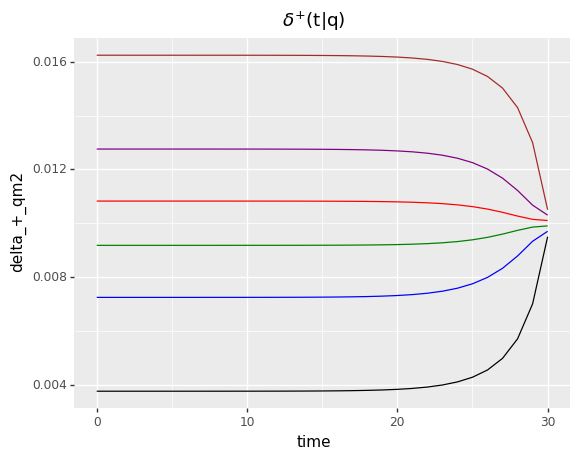

<ggplot: (8740269081909)>

time: 876 ms (started: 2022-07-29 21:02:16 +00:00)


In [ ]:
delta_over_time = pd.DataFrame({ "time" : np.arange(int(T+1)).tolist(), 
               "delta_-_qm3" : [ _smallDelta_minus(qbar_short, qbar_long, x5[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_qm2" : [ _smallDelta_plus(qbar_short, qbar_long, x[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_-_qm2" : [ _smallDelta_minus(qbar_short, qbar_long, x[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_qm1" : [ _smallDelta_plus(qbar_short, qbar_long, x1[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_-_qm1" : [ _smallDelta_minus(qbar_short, qbar_long, x1[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_q0" : [_smallDelta_plus(qbar_short, qbar_long, x2[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_-_q0" : [ _smallDelta_minus(qbar_short, qbar_long, x2[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_q1" : [ _smallDelta_plus(qbar_short, qbar_long, x3[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_-_q1" : [ _smallDelta_minus(qbar_short, qbar_long, x3[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_q2" : [_smallDelta_plus(qbar_short, qbar_long, x4[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_-_q2" : [ _smallDelta_minus(qbar_short, qbar_long, x4[t]).item() for t in np.arange(int(T+1))[::-1] ],
               "delta_+_q3" : [ _smallDelta_plus(qbar_short, qbar_long, x6[t]).item() for t in np.arange(int(T+1))[::-1] ],
             })
ggplot(delta_over_time, aes(x='time')) + geom_line(aes(y='delta_+_qm2'), color = "brown") + geom_line(aes(y='delta_+_qm1'), color = "purple") + geom_line(aes(y='delta_+_q0'), color = "red") + geom_line(aes(y='delta_+_q1'), color = "green") + geom_line(aes(y='delta_+_q2'), color = "blue") + geom_line(aes(y='delta_+_q3'), color = "black") + ggtitle("$\delta^{+}$(t|q)")
#ggplot(delta_over_time, aes(x='time')) + geom_line(aes(y='delta_-_qm3'), color = "black") + geom_line(aes(y='delta_-_qm2'), color = "brown") + geom_line(aes(y='delta_-_qm1'), color = "purple") + geom_line(aes(y='delta_-_q0'), color = "red") + geom_line(aes(y='delta_-_q1'), color = "green") + geom_line(aes(y='delta_-_q2'), color = "blue") + ggtitle("$\delta^{-}$(t|q)")


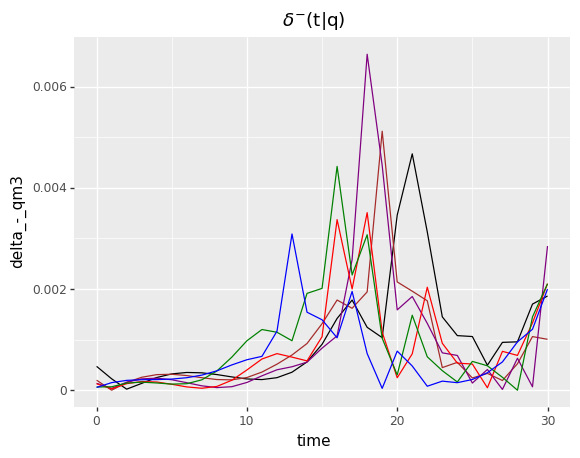

<ggplot: (8740268958429)>

time: 536 ms (started: 2022-07-29 21:02:19 +00:00)


In [ ]:
delta_over_time_pred = pd.DataFrame({ "time" : np.arange(int(T+1)).tolist(), 
               "delta_-_qm3" : control_net_plus(torch.flip(x5, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_qm2" : control_net_plus(torch.flip(x, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
               "delta_-_qm2" : control_net_plus(torch.flip(x, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_qm1" : control_net_plus(torch.flip(x1, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
               "delta_-_qm1" : control_net_plus(torch.flip(x1, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_q0" : control_net_plus(torch.flip(x2, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
               "delta_-_q0" : control_net_plus(torch.flip(x2, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_q1" : control_net_plus(torch.flip(x3, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
               "delta_-_q1" : control_net_plus(torch.flip(x3, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_q2" : control_net_plus(torch.flip(x4, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
               "delta_-_q2" : control_net_plus(torch.flip(x4, dims=[0]).cuda())[:, 1].cpu().detach().numpy().flatten().tolist(),
               
               "delta_+_q3" : control_net_plus(torch.flip(x6, dims=[0]).cuda())[:, 0].cpu().detach().numpy().flatten().tolist(),
             })
#ggplot(delta_over_time_pred, aes(x='time')) + geom_line(aes(y='delta_+_qm2'), color = "brown") + geom_line(aes(y='delta_+_qm1'), color = "purple") + geom_line(aes(y='delta_+_q0'), color = "red") + geom_line(aes(y='delta_+_q1'), color = "green") + geom_line(aes(y='delta_+_q2'), color = "blue") +  geom_line(aes(y='delta_+_q3'), color = "black") + ggtitle("$\delta^{+}$(t|q)")
ggplot(delta_over_time_pred, aes(x='time')) + geom_line(aes(y='delta_-_qm3'), color = "black") + geom_line(aes(y='delta_-_qm2'), color = "brown") + geom_line(aes(y='delta_-_qm1'), color = "purple") + geom_line(aes(y='delta_-_q0'), color = "red") + geom_line(aes(y='delta_-_q1'), color = "green") + geom_line(aes(y='delta_-_q2'), color = "blue") + ggtitle("$\delta^{-}$(t|q)")


If we want to resume:

In [ ]:
filepath = '/content/drive/MyDrive/DGM'
filename = 'CJ_sec10_2_state_saved_110000_epochs_1-value-ep_10-control-ep-64_neurons_1layer_control_plus_minus.pt'
state = torch.load(os.path.join(filepath, filename))

sync_flag=False
variable_dims_value = [0, 1, 2, 3]
variable_dims_control = [0, 3]

# ANSATZ IS TEMPORARY - REMOVE AFTERWARDS
value_net = AlternativeNet( in_size = 4, out_size = 1, neurons = 64, depth=2, batch_normalize=False, add_cross=False, var_dims=variable_dims_value )
value_net.load_state_dict(state['value_state_dict'])
value_net.to(torch.device("cuda:0")) 

control_net_plus = AlternativeNet( in_size = 2 , out_size = 2, neurons = 64, depth=1, batch_normalize=False, add_cross=False, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1.)
control_net_plus.load_state_dict(state['control_state_plus_minus_dict'])
control_net_plus.to(torch.device("cuda:0"))


control_net_minus = AlternativeNet( in_size = 2 , out_size = 1, neurons = 64, depth=1, batch_normalize=False, add_cross=False, var_dims=variable_dims_control, final_activation=torch.abs, scale_factor=1.)
#control_net_minus.load_state_dict(state['control_state_minus_dict'])
control_net_minus.to(torch.device("cuda:0"))

max_control_epochs = 1 # has to be low!!!
num_of_value_iters = 2
eqLossFn= 'calculateLoss'
sample_method= "U"
lr = 3e-4
lr_for_control = 3e-4


value_equation = ValueEquation(value_net, control_net_plus, control_net_minus, max_control_epochs, lr_for_control, sync_flag=sync_flag)
value_equation.control_optim_state_plus = state['control_optimizer_plus_minus_state_dict']
#value_equation.control_optim_state_minus = state['control_optimizer_minus_state_dict']


trainAlloc = TrainHJBWithDGM(value_equation, BATCH_SIZE=2048, lr=lr, num_of_value_iters=num_of_value_iters, hook_interval=200)
trainAlloc.stop_epoch = state['epoch']
trainAlloc.optimizer_used.load_state_dict(state['value_optimizer_state_dict'])

#trainAlloc.train(epoch = 20000, eqLossFn = eqLossFn, sample_method_X = sample_method)

time: 92.5 ms (started: 2022-07-29 12:07:10 +00:00)


Text(0.5, 1.0, 'Learning rate scheduler')

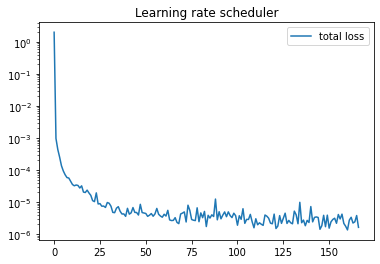

time: 483 ms (started: 2022-07-29 21:02:32 +00:00)


In [ ]:
plt.plot(np.array(trainAlloc.train_losses)[:, 0])
#plt.plot(np.array(trainAlloc.train_losses)[:, 2:].sum(axis=1))
plt.yscale('log')
plt.legend(['total loss'])
#plt.legend(['total loss', 'total mse'])
plt.title('Learning rate scheduler')

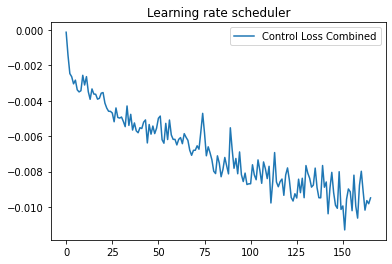

time: 126 ms (started: 2022-07-29 21:02:37 +00:00)


In [ ]:
plt.plot(np.array(value_equation.control_losses))
plt.legend(['Control Loss Combined',])
plt.title('Learning rate scheduler')
plt.show()

In [ ]:
internal_sample, terminal_sample = trainAlloc.model.sample(size=1024, to_cpu=False)
all_samples = torch.cat([internal_sample, terminal_sample], dim=0)

time: 3.69 ms (started: 2022-07-29 17:02:10 +00:00)


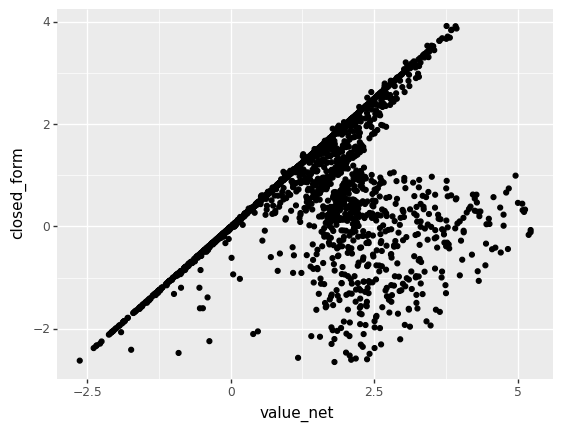

<ggplot: (8755832691045)>

time: 2.43 s (started: 2022-07-29 17:02:11 +00:00)


In [ ]:
value_net_results = trainAlloc.model.value_net(all_samples).detach().cpu().numpy().reshape(-1).tolist()
htx_results = torch.cat([_bigH_Value(-3, 3, all_samples[t]) for t in range(all_samples.shape[0])]).cpu().detach().numpy().reshape(-1).tolist()

dataf2 = pd.DataFrame( { 'value_net': value_net_results, 'closed_form': htx_results } )
ggplot(dataf2, aes(x='value_net', y='closed_form')) + geom_point()

In [ ]:
np.mean((dataf2['value_net'] - dataf2['closed_form']) ** 2)

0.007329555985145996

time: 7.97 ms (started: 2022-07-28 16:59:05 +00:00)


In [ ]:
np.mean(np.abs(dataf2['value_net'] - dataf2['closed_form']))

0.05226487288325643

time: 6.36 ms (started: 2022-07-28 16:59:08 +00:00)


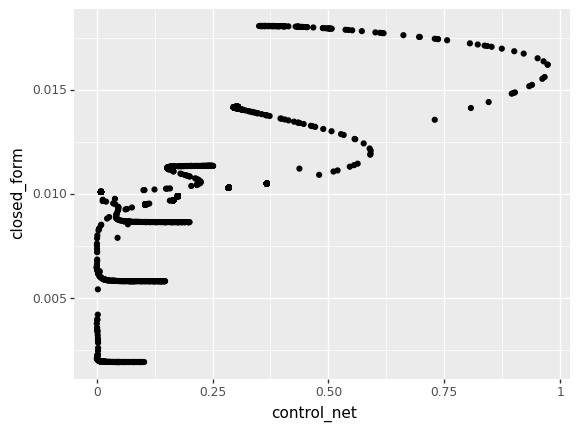

<ggplot: (8755832679281)>

time: 2.26 s (started: 2022-07-29 17:02:18 +00:00)


In [ ]:
# plot the control function vs the closed form (ideally straight line...)

mask_minus = all_samples[:, 3] != 3
all_samples_masked = all_samples[mask_minus]

dataf = pd.DataFrame( { 'control_net': value_equation.control_net_plus(all_samples_masked)[:, 1].cpu().detach().numpy().reshape(-1).tolist(), 
                       'closed_form': torch.cat([_smallDelta_minus(-3, 3, all_samples_masked[t]).unsqueeze(0) for t in range(all_samples_masked.shape[0])]).cpu().detach().numpy().reshape(-1).tolist() } )

ggplot(dataf, aes(x='control_net', y='closed_form')) + geom_point()

In [ ]:
np.mean(np.abs(dataf['control_net'] - dataf['closed_form']))

0.18662234502300096

time: 5.77 ms (started: 2022-07-29 17:02:26 +00:00)


In [ ]:
dataf.corr()

,control_net,closed_form
control_net,1.000000,0.689329
closed_form,0.689329,1.000000


time: 9.16 ms (started: 2022-07-29 17:02:27 +00:00)


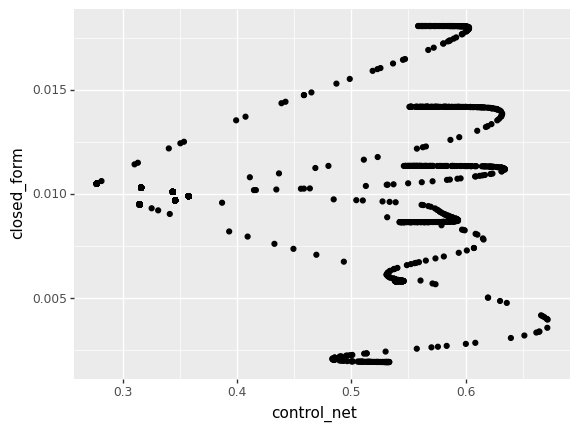

<ggplot: (8755832923325)>

time: 2.29 s (started: 2022-07-29 17:02:29 +00:00)


In [ ]:
# plot the control function vs the closed form (ideally straight line...)

mask_plus = all_samples[:, 3] != -3
all_samples_masked = all_samples[mask_plus]

dataf = pd.DataFrame( { 'control_net': value_equation.control_net_plus(all_samples_masked)[:,0].cpu().detach().numpy().reshape(-1).tolist(), 
                       'closed_form': torch.cat([_smallDelta_plus(-3, 3, all_samples_masked[t]).unsqueeze(0) for t in range(all_samples_masked.shape[0])]).cpu().detach().numpy().reshape(-1).tolist() } )

ggplot(dataf, aes(x='control_net', y='closed_form')) + geom_point()

In [ ]:
dataf.corr()

,control_net,closed_form
control_net,1.000000,0.799277
closed_form,0.799277,1.000000


time: 9.99 ms (started: 2022-07-29 13:06:14 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/DGM'

Mounted at /content/drive
time: 18.5 s (started: 2022-07-23 11:00:32 +00:00)


In [ ]:
torch.save(trainAlloc.model.value_net.state_dict(), os.path.join(filepath, 'CJ_value_net_trained_130k_epochs_lr_3e-4_multistep.pt'))
torch.save(value_equation.control_net.state_dict(), os.path.join(filepath, 'CJ_control_net_trained_130k_epochs_2ep_lr_1e-3.pt'))

time: 37.9 ms (started: 2022-07-13 20:45:11 +00:00)
